This notebook extracts features and then creates ML models for all wavelets, where DWT is performed on the whole event

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import signal
from scipy.signal import find_peaks, peak_widths
import pyabf
import pyabf.filter
from multiprocessing import Pool
import pywt

from scipy.optimize import curve_fit
from scipy.stats import poisson
from scipy.stats import norm
from scipy.stats import skew
from scipy.stats import kurtosis
import seaborn as sns
from scipy.stats import randint

from matplotlib.ticker import MaxNLocator
import sklearn
from sklearn.cluster import DBSCAN
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

from scipy.stats import entropy
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.pipeline import Pipeline
from sklearn.model_selection import KFold

In [27]:
import pickle

def save_with_pickle(file_name, data):
    with open(file_name, 'wb') as file:
        pickle.dump(data, file)

In [228]:
import importlib
import all_funcs
importlib.reload(all_funcs)
from all_funcs import *

In [34]:
def lowpassfilter(signal, thresh=0.3, wavelet="coif4"):
    thresh = thresh * np.nanmax(signal)
    coeffs = pywt.wavedec(signal, wavelet, mode="per")

    # Apply thresholding
    coeffs[1:] = [pywt.threshold(i, value=thresh, mode="soft") for i in coeffs[1:]] # was soft

    reconstructed_signal = pywt.waverec(coeffs, wavelet, mode="per")
    return reconstructed_signal, coeffs

### Single

Event isolation

In [158]:
base_path = "/Users/joehart/Desktop/chemistry/Year 4/MSci project/MATLAB/5_nm_AuNP_SDS_in_50_mM_KCl_PEG_35k_bath/"
file_template = "p18_31_50mM_KCl_5nmAunP_SDS_i2o_PEG35k_500mV_{}.abf"

paths_5 = [base_path + file_template.format(str(i).zfill(4)) for i in range(2, 8)]

base_path = "/Users/joehart/Desktop/chemistry/Year 4/MSci project/MATLAB/10_nm_AuNP_SDS_in_50_mM_KCl_with_PEG_35k_bath/"
file_template = "p18_4_50mM_KCl_10nmAunP_SDS_i2o_PEG35k_{}.abf"

paths_10 = [base_path + file_template.format(str(i).zfill(4)) for i in range(2, 21)]

paths = paths_5 + paths_10

In [14]:
paths[0]

'/Users/joehart/Desktop/chemistry/Year 4/MSci project/MATLAB/5_nm_AuNP_SDS_in_50_mM_KCl_PEG_35k_bath/p18_31_50mM_KCl_5nmAunP_SDS_i2o_PEG35k_500mV_0002.abf'

In [160]:
# performing DWT on whole event
# notebook 6 has most upto date version of this function
def load_to_event_DWT_wholeevent_isolation(path, thresh = 0.1, resistive = False):
    x, y, sma, y_corrected, y_base, x_base = importABF_movingavg(path, resistive) 
    
    threshold, mean_noise, sd_noise = define_threshold(y_base, 12)
    
    DWT_rec, all_coeffs = lowpassfilter_all(y_base, thresh=thresh, wavelet="coif5")
    DWT_rec, all_coeffs = DWT_rec[:len(y_base)], list(all_coeffs) # didnt convert to list as find_peaks_troughs takes an array
    
    sd_threshold, sd_threshold_lower, peaks_above, properties_above, peaks_below, properties_below = find_peaks_troughs(mean_noise, sd_noise, DWT_rec, x_base, resistive)
    
    if resistive:
        event_time, event_data, smo = event_isolation(x_base, DWT_rec, peaks_above, properties_above, peaks_below, properties_below)
    else:
        event_time, event_data, smo = event_isolation(x_base, DWT_rec, peaks_above, properties_above)        
    
    
    return event_time, event_data, DWT_rec, sd_threshold, sd_threshold_lower, mean_noise, peaks_above, peaks_below, all_coeffs

In [161]:
def load_to_event_DWT_wholeevent_isolation(path, thresh, wavelet, resistive = False, plot = False, NRNS = False):
    x, y, sma, y_corrected, y_base, x_base = importABF_movingavg(path, resistive) 
    
    threshold, mean_noise, sd_noise = define_threshold(y_base, 12)
    
    DWT_rec, all_coeffs = lowpassfilter_all(y_base, thresh=thresh, wavelet=wavelet)
    DWT_rec, all_coeffs = DWT_rec[:len(y_base)], list(all_coeffs) # didnt convert to list as find_peaks_troughs takes an array
    
    sd_threshold, sd_threshold_lower, peaks_above, properties_above, peaks_below, properties_below = find_peaks_troughs(mean_noise, sd_noise, DWT_rec, x_base, resistive, plot = plot)
    
    if NRNS: # option for different event isolation function
        event_time, event_data = event_isolation_NRNS(x_base, y_base, peaks_above, NP = True)
        smo = None
    if resistive:
        event_time, event_data, smo = event_isolation(x_base, DWT_rec, peaks_above, properties_above, peaks_below, properties_below)
    else:
        event_time, event_data, smo = event_isolation(x_base, DWT_rec, peaks_above, properties_above)        
    
    
    return event_time, event_data, DWT_rec, sd_threshold, sd_threshold_lower, mean_noise, peaks_above, peaks_below, all_coeffs


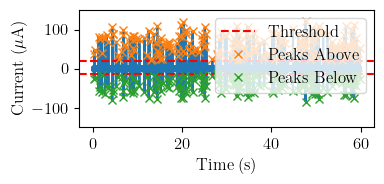

In [163]:
path = "/Users/joehart/Desktop/chemistry/Year 4/MSci project/MATLAB/5_nm_AuNP_SDS_in_50_mM_KCl_PEG_35k_bath/p18_31_50mM_KCl_5nmAunP_SDS_i2o_PEG35k_500mV_0003.abf"
event_time_DWTwhole_5nm_0003, event_data_DWTwhole_5nm_0003, DWT_rec_DWTwhole_5nm_0003, sd_threshold_DWTwhole_5nm_0003, sd_threshold_lower_DWTwhole_5nm_0003, mean_noise_DWTwhole_5nm_0003, peaks_above_DWTwhole_5nm_0003, peaks_below_DWTwhole_5nm_0003, all_coeffs_DWTwhole_5nm_0003 = load_to_event_DWT_wholeevent_isolation(paths[1], thresh = 0.1, wavelet = "coif4", resistive = True, plot = True, NRNS = True)

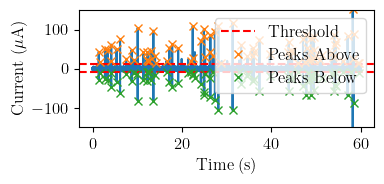

In [172]:
event_time_DWTwhole_10nm_0003, event_data_DWTwhole_10nm_0003, DWT_rec_DWTwhole_10nm_0003, sd_threshold_DWTwhole_10nm_0003, sd_threshold_lower_DWTwhole_10nm_0003, mean_noise_DWTwhole_10nm_0003, peaks_above_DWTwhole_10nm_0003, peaks_below_DWTwhole_10nm_0003, all_coeffs_DWTwhole_10nm_0003 = load_to_event_DWT_wholeevent_isolation(paths[8], thresh = 0.1, wavelet = "coif4", resistive = True, plot = True, NRNS = True)


In [4]:
import re

def extract_details(file_path):
    # Extracting the nm part (5nm or 10nm)
    nm_match = re.search(r'_(5nm|10nm)AunP_', file_path)
    nm_detail = nm_match.group(1) if nm_match else None

    # Extracting the last 4 digits
    digits_match = re.search(r'_(\d{4})\.', file_path)
    last_four_digits = digits_match.group(1) if digits_match else None

    return nm_detail, last_four_digits

# Example usage
file_path = "p18_31_50mM_KCl_5nmAunP_SDS_i2o_PEG35k_500mV_0003.abf"
nm_detail, last_four_digits = extract_details(file_path)

print("nm detail:", nm_detail)
print("Last four digits:", last_four_digits)

nm detail: 5nm
Last four digits: 0003


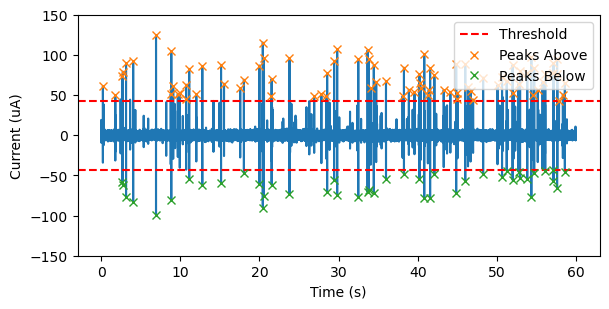

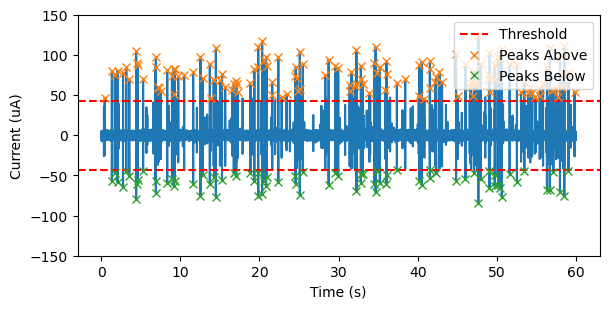

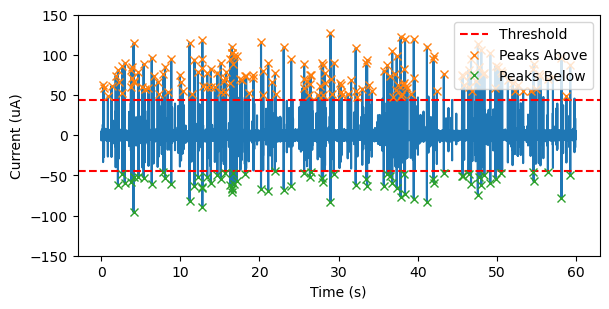

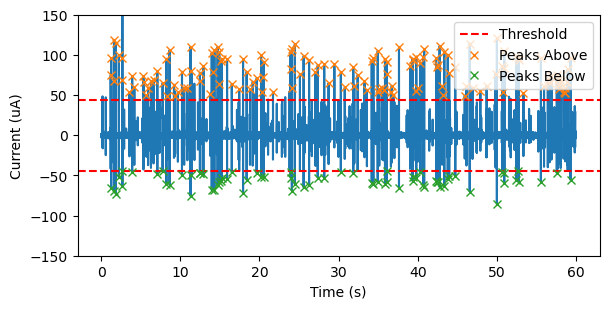

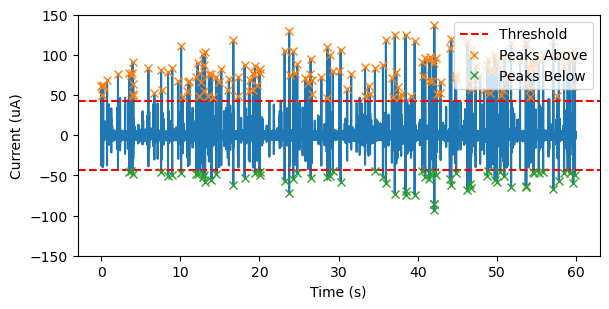

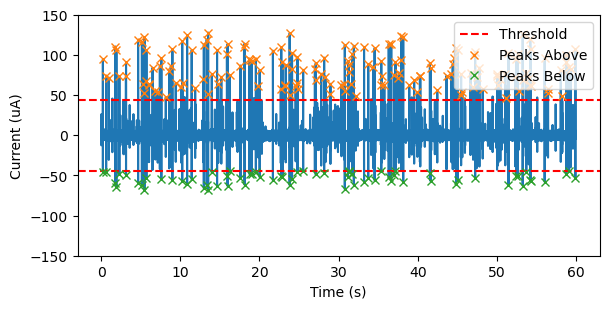

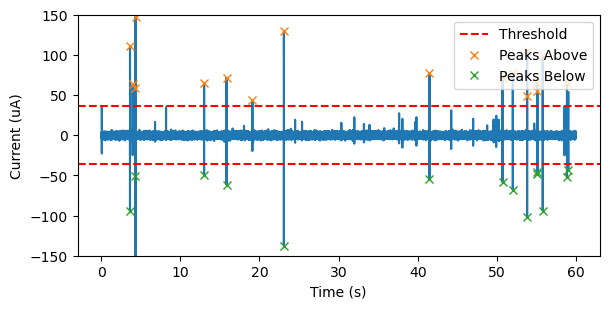

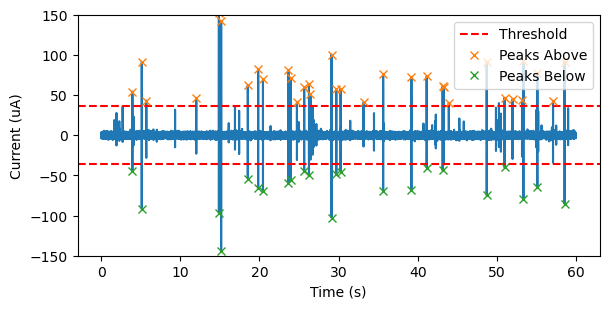

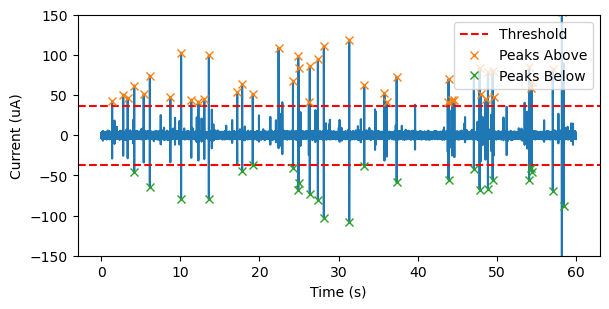

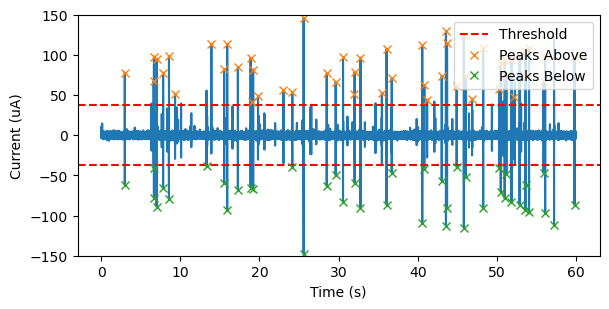

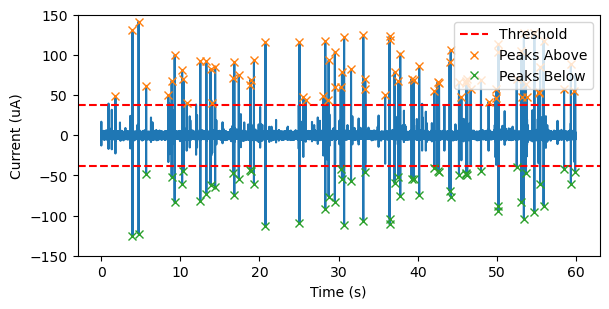

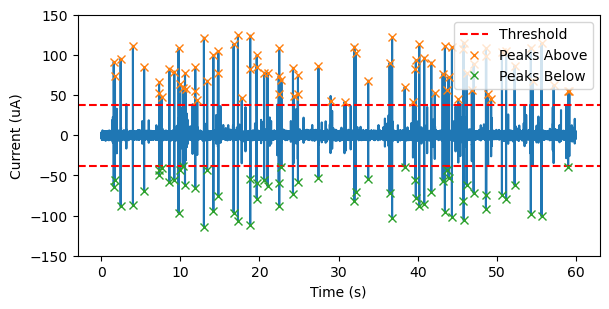

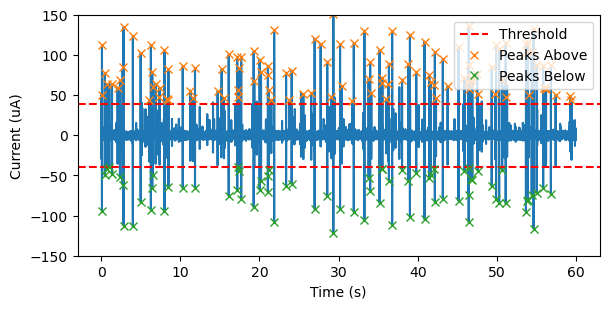

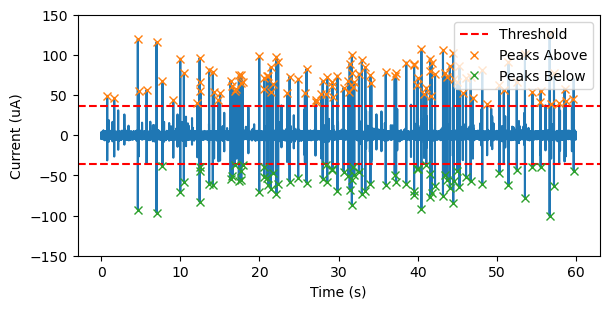

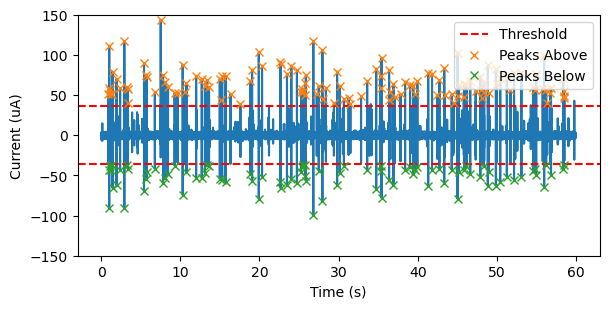

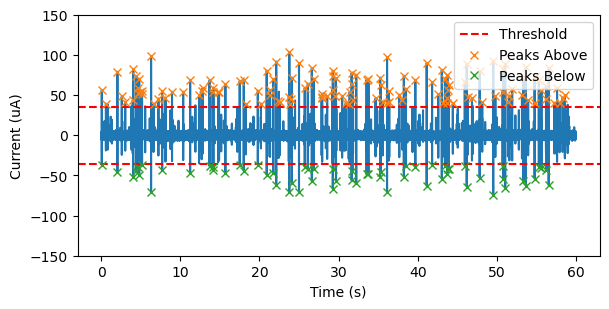

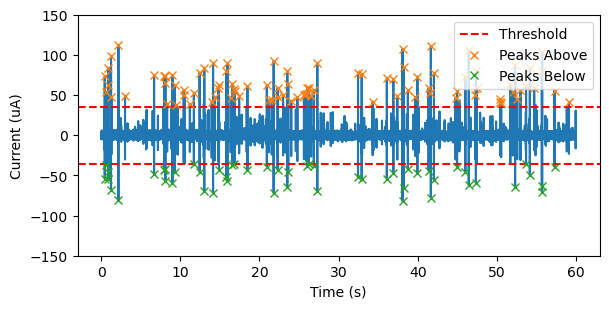

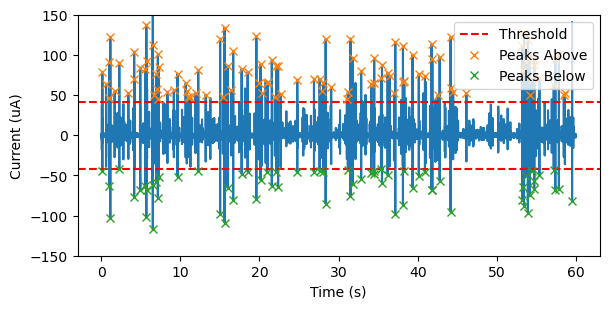

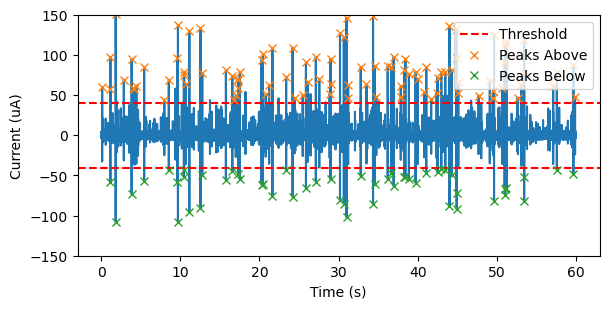

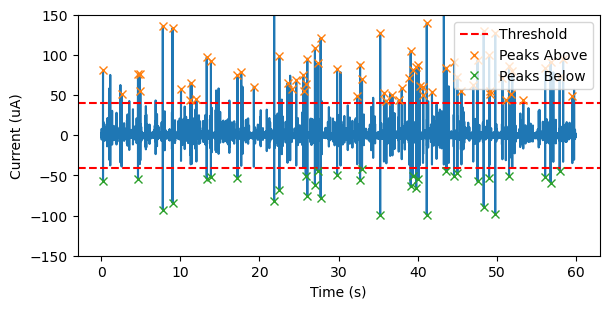

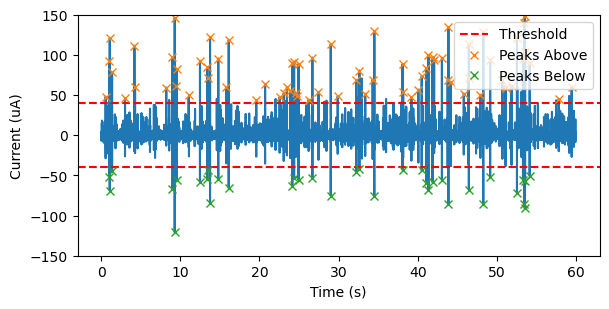

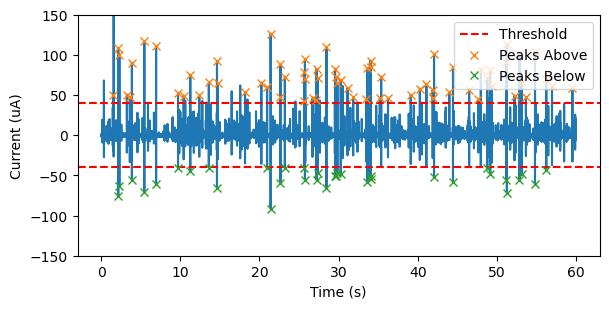

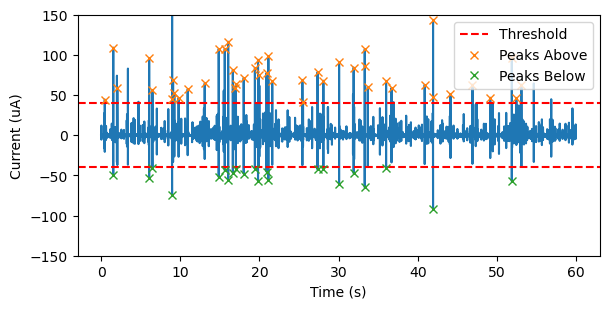

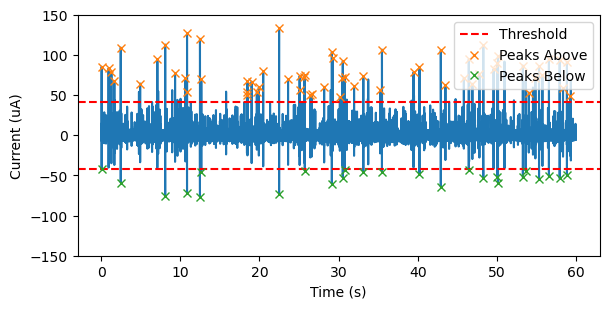

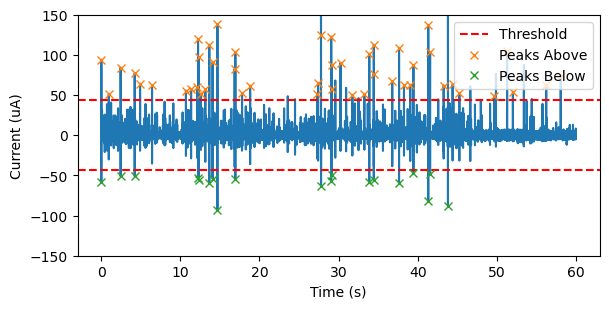

In [19]:
results_wholeeventDWT = {}

for path in paths:
    nm_detail, identifier = extract_details(path)

    if nm_detail and identifier:
        key_prefix = f"{nm_detail}_{identifier}"
    else:
        continue  # Skip the file if the required details are not found

    output = load_to_event_DWT_wholeevent_isolation(path, resistive=True)

    # Store each piece of output with a dynamic key
    results_wholeeventDWT[f'event_time_{key_prefix}'] = output[0]
    results_wholeeventDWT[f'event_data_{key_prefix}'] = output[1]
    results_wholeeventDWT[f'DWT_rec_{key_prefix}'] = output[2]
    results_wholeeventDWT[f'sd_threshold_{key_prefix}'] = output[3]
    results_wholeeventDWT[f'sd_threshold_lower_{key_prefix}'] = output[4]
    results_wholeeventDWT[f'mean_noise_{key_prefix}'] = output[5]
    results_wholeeventDWT[f'peaks_above_{key_prefix}'] = output[6]
    results_wholeeventDWT[f'peaks_below_{key_prefix}'] = output[7]
    results_wholeeventDWT[f'all_coeffs{key_prefix}'] = output[8]


In [43]:
save_with_pickle('results_wholeeventDWT_dic.pkl', results_wholeeventDWT)

Feature extraction

In [5]:
results_wholeeventDWT = unpickle('results_wholeeventDWT_dic.pkl')

In [22]:
def features_DWT_whole(event_time, event_data, mean_noise, sd_threshold, sd_threshold_lower, all_coeffs, NP_size):
    # extracting features after DWT of whole trace + event isolation
    event_time_padded, event_data_padded = pad_event(event_time, event_data, mean_noise)
    features_df, features_list =  find_features_CWT(event_time_padded, event_data_padded, mean_noise, all_coeffs, sd_threshold, sd_threshold_lower)
    
    if NP_size == 5:
        labels = list(np.zeros(len(features_list)))
    else:
        labels = list(np.ones(len(features_list)))
    
    return event_time_padded, event_data_padded, features_df, features_list, labels

In [164]:
event_time_padded_DWTwhole_5nm_0003, event_data_padded_DWTwhole_5nm_0003, features_df_DWTwhole_5nm_0003, features_list_DWTwhole_5nm_0003, labels_DWTwhole_5nm_0003 = features_DWT_whole(event_time_DWTwhole_5nm_0003, event_data_DWTwhole_5nm_0003, mean_noise_DWTwhole_5nm_0003, sd_threshold_DWTwhole_5nm_0003, sd_threshold_lower_DWTwhole_5nm_0003, all_coeffs_DWTwhole_5nm_0003, 5)

In [173]:
event_time_padded_DWTwhole_10nm_0003, event_data_padded_DWTwhole_10nm_0003, features_df_DWTwhole_10nm_0003, features_list_DWTwhole_10nm_0003, labels_DWTwhole_10nm_0003 = features_DWT_whole(event_time_DWTwhole_10nm_0003, event_data_DWTwhole_10nm_0003, mean_noise_DWTwhole_10nm_0003, sd_threshold_DWTwhole_10nm_0003, sd_threshold_lower_DWTwhole_10nm_0003, all_coeffs_DWTwhole_10nm_0003, 10)

Get identifiers + convert to df

In [6]:
def sort_identifiers(details):
    nm_order = 0 if details[0] == '5nm' else 1
    numeric_part = int(details[1]) if details[1] is not None else float('inf')
    return nm_order, numeric_part

unique_identifiers = [extract_details(path) for path in paths]

unique_identifiers_sorted = sorted(unique_identifiers, key=sort_identifiers)
sorted_identifiers = ['_'.join(identifier) for identifier in unique_identifiers_sorted]

# final line: ('5nm', '0002') -> '5nm_0002'

print(sorted_identifiers)


['5nm_0002', '5nm_0003', '5nm_0004', '5nm_0005', '5nm_0006', '5nm_0007', '10nm_0002', '10nm_0003', '10nm_0004', '10nm_0005', '10nm_0006', '10nm_0007', '10nm_0008', '10nm_0009', '10nm_0010', '10nm_0011', '10nm_0012', '10nm_0013', '10nm_0014', '10nm_0015', '10nm_0016', '10nm_0017', '10nm_0018', '10nm_0019', '10nm_0020']


In [42]:
columns = ['event_time_padded', 'event_data_padded', 'features_df', 'features_list', 'labels']

df_features_DWTwhole_updated = pd.DataFrame(columns=columns)

for identifier in sorted_identifiers:
    # Construct the keys for each data type (for extraction from dic)
    event_time_key = f'event_time_{identifier}'
    event_data_key = f'event_data_{identifier}'
    mean_noise_key = f'mean_noise_{identifier}'
    sd_threshold_key = f'sd_threshold_{identifier}'
    sd_threshold_lower_key = f'sd_threshold_lower_{identifier}'
    all_coeffs_key = f'DWT_rec_{identifier}'

    # Extract the relevant data for this identifier
    event_time = results_wholeeventDWT.get(event_time_key)
    event_data = results_wholeeventDWT.get(event_data_key)
    mean_noise = results_wholeeventDWT.get(mean_noise_key)
    sd_threshold = results_wholeeventDWT.get(sd_threshold_key)
    sd_threshold_lower = results_wholeeventDWT.get(sd_threshold_lower_key)
    all_coeffs = results_wholeeventDWT.get(all_coeffs_key)

    # Determine NP size from the identifier
    NP_size = int(identifier.split('_')[0][:-2])  # Extract '5' or '10' from '5nm' or '10nm'


    event_time_padded, event_data_padded, features_df, features_list, labels = features_DWT_whole(
        event_time, event_data, mean_noise, sd_threshold, sd_threshold_lower, all_coeffs, NP_size)

    # Append the results to the DataFrame
    df_features_DWTwhole_updated.loc[identifier] = {
        'event_time_padded': event_time_padded,
        'event_data_padded': event_data_padded,
        'features_df': features_df,
        'features_list': features_list,
        'labels': labels
    }


In [84]:
df_features_DWTwhole.to_pickle('df_features_DWTwhole.pkl')

In [43]:
df_features_DWTwhole_updated.to_pickle('df_features_DWTwhole_updated.pkl')

In [7]:
df_features_DWTwhole_updated = unpickle('df_features_DWTwhole_updated.pkl')

In [93]:
df_features_DWTwhole['features_list'][:23]

5nm_0002     [[61.216363193645115, -34.06296657639039, 1.79...
5nm_0003     [[46.72829476493834, -24.80811826366162, 1.883...
5nm_0004     [[63.27467042337339, -33.339598489998195, 1.89...
5nm_0005     [[74.74857928649557, -41.51926410056263, 1.800...
5nm_0006     [[60.87339638226578, -37.94694651590041, 1.604...
5nm_0007     [[94.63068529437423, -45.283242241152344, 2.08...
10nm_0002    [[111.08797811520209, -94.71045374177278, 1.17...
10nm_0003    [[54.59651136452568, -44.53085749997272, 1.226...
10nm_0004    [[42.83892138935992, -28.95777105318091, 1.479...
10nm_0005    [[78.22774120647853, -61.81529102181619, 1.265...
10nm_0006    [[48.38750393464956, -22.617499924788863, 2.13...
10nm_0007    [[91.70060029559006, -64.0775301937552, 1.4310...
10nm_0008    [[50.500848330686175, -29.555426136248997, 1.7...
10nm_0009    [[49.272816039690575, -31.26571158155332, 1.57...
10nm_0010    [[51.76078137937572, -32.4220800594176, 1.5964...
10nm_0011    [[56.720532026696965, -36.82880246550308, 

In [39]:
len(X_DWTwhole[1])

20

flatten features df (located inside overall df) + exclude 1920

In [44]:
# excluding the 1920 events
X_DWTwhole = []
for row in df_features_DWTwhole_updated['features_list'][:23]:
    for sublist in row:
        X_DWTwhole.append(sublist)
        
y_labels_DWTwhole = []
for row in df_features_DWTwhole_updated['labels'][:23]:
    for sublist in row:
        y_labels_DWTwhole.append(sublist)

In [45]:
save_with_pickle('X_DWTwhole.pkl', X_DWTwhole)
save_with_pickle('y_labels_DWTwhole.pkl', y_labels_DWTwhole)

### ML model

In [169]:
def ML_Kfold(features, labels, nfolds, model):
    scaler = RobustScaler()
    X = scaler.fit_transform(features)
    y = labels

    # Initialize k-fold cross-validation
    kf = KFold(n_splits=nfolds)

    # Create a pipeline with SMOTE and the specified model
    clf_pipeline = Pipeline([
        ('smote', SMOTE(random_state=42)),
        ('model', model())
    ])

    # Perform k-fold CV
    accuracies = cross_val_score(clf_pipeline, X, y, cv=kf, scoring='accuracy', n_jobs=-1)  # Use parallel processing

    # Calculate average accuracy
    average_accuracy = np.mean(accuracies)

    return average_accuracy

In [47]:
models = [DecisionTreeClassifier, RandomForestClassifier, XGBClassifier, SVC]
model_names = ['DecisionTree', 'RandomForest', 'XGBoost', 'SVM']


for model in models:
    print(model_names[models.index(model)])
    print(ML_Kfold(X_DWTwhole, y_labels_DWTwhole, 10, model))

DecisionTree
0.8723054275473631
RandomForest
0.89810547875064
XGBoost
0.8995114353985322
SVM
0.8976190476190478


In [52]:
scaler = RobustScaler()
X_ = X_DWTwhole
y_ = y_labels_DWTwhole

X_train_, X_test_, y_train_, y_test_ = train_test_split(X_, y_, test_size=0.2, random_state=42)

X_train_scaled = scaler.fit_transform(X_train_)
X_test_scaled = scaler.transform(X_test_)


# Initialize k-fold cross-validation
kf_ = KFold(n_splits=10)

# Create a pipeline with SMOTE and the specified model
clf_pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('model', RandomForestClassifier())
])

# Perform k-fold CV
accuracies_ = cross_val_score(clf_pipeline, X_train_, y_train_, cv=kf_, scoring='accuracy', n_jobs=-1)  # Use parallel processing

# Calculate average accuracy
average_accuracy_ = np.mean(accuracies_)
average_accuracy_


0.936588930968042

In [53]:
clf_pipeline.fit(X_train_, y_train_)
clf_pipeline.score(X_test_, y_test_)

0.9354838709677419

### All wavelets

In [54]:
base_data = {}

for path in paths:
    nm_detail, identifier = extract_details(path)

    if nm_detail and identifier:
        key_prefix = f"{nm_detail}_{identifier}"
    else:
        continue  # Skip if required details are not found

    # Gather base data
    x, y, sma, y_corrected, y_base, x_base = importABF_movingavg(path, resistive = True) 
    threshold, mean_noise, sd_noise = define_threshold(y_base, 12) 
       
    base_data[key_prefix] = {
        'y_base': y_base, 
        'x_base': x_base, 
        'mean_noise': mean_noise, 
        'sd_noise': sd_noise
    }


In [57]:
save_with_pickle('base_data.pkl', base_data)

In [2]:
base_data = unpickle('base_data.pkl')

In [3]:
NP_sizes_all_wavelets = [5,5,5,5,5,5,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10]

In [5]:
wavelets = pywt.wavelist(kind='discrete')


In [152]:
DWT_rec_test, all_coeffs_test = lowpassfilter_all(base_data['5nm_0003']["y_base"], thresh=0.1, wavelet="coif5")

DWT_rec_test, all_coeffs_test = DWT_rec_test[:len(base_data['5nm_0003']["y_base"])], list(all_coeffs_test)

sd_threshold_test, sd_threshold_lower_test, peaks_above_test, properties_above_test, peaks_below_test, properties_below_test = find_peaks_troughs(base_data['5nm_0003']["mean_noise"], base_data['5nm_0003']["sd_noise"], DWT_rec_test, base_data['5nm_0003']["x_base"], resistive=True)

#event_time_test, event_data_test, event_start_end_idx_test = event_isolation(base_data['5nm_0003']["x_base"], DWT_rec_test, peaks_above_test, properties_above_test, peaks_below_test, properties_below_test)
event_time_test, event_data_test = event_isolation_NRNS(base_data['5nm_0003']["x_base"], DWT_rec_test, peaks_above_test, NP = True)

event_time_padded_test, event_data_padded_test = pad_event(event_time_test, event_data_test, base_data['5nm_0003']["mean_noise"])

In [113]:
event_start_end_idx_test[0][0]

170142

In [148]:
trace_test = peak_tracer_wholeevent(event_data_test, base_data['5nm_0003']["y_base"], event_start_end_idx_test, sd_threshold_test, sd_threshold_lower_test)

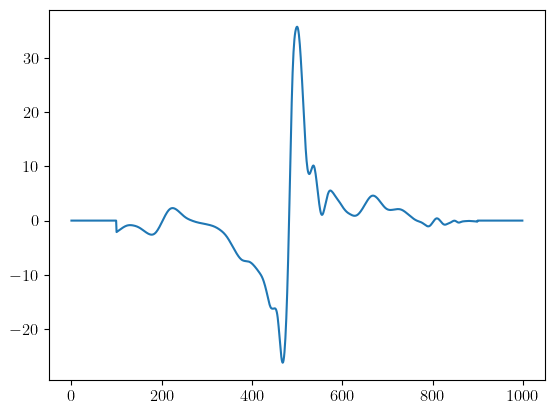

In [154]:
plt.plot(event_data_padded_test[0])
#plt.plot(base_data['5nm_0003']["y_base"][event_start_end_idx_test[0][0]:event_start_end_idx_test[0][1]])

In [143]:
def peak_tracer_wholeevent(event_data, y_base, event_start_end_idx, threshold_upper, threshold_lower = None):


    traced_data = event_data.copy()
    range_offset = 10

    for i in range(len(traced_data)):
        start_event_idx = event_start_end_idx[i][0]
        end_event_idx = event_start_end_idx[i][1]
        event_raw = y_base[start_event_idx:end_event_idx] #[:len(event_data[i])]
        

        peak_above_idx = np.argmax(event_raw)
        start_above_idx = max(0, peak_above_idx - range_offset)
        end_above_idx = min(len(event_raw), peak_above_idx + range_offset)
        # +11 because slicing is exclusive at the end
        idx_above = np.arange(start_above_idx, end_above_idx)

        for idx in idx_above:
            if event_raw[idx] > threshold_upper:
                traced_data[i][idx] = event_raw[idx]

        if threshold_lower is not None :
            peak_below_idx = np.argmin(event_raw)
            start_below_idx = max(0, peak_below_idx - range_offset)
            end_below_idx = min(len(event_raw), peak_below_idx + range_offset)
            idx_below = np.arange(start_below_idx, end_below_idx)
                        
            for idx in idx_below:
                if event_raw[idx] < threshold_lower:
                    traced_data[i][idx] = event_raw[idx]
            


    return traced_data

In [210]:
def apply_wavelet_transformations(wavelet_list, y_base, x_base, mean_noise, sd_noise,resistive=False, threshold=0.1, NRNS = False):

    event_times, event_times_padded, event_datas, event_datas_padded, DWT_recs, sd_thresholds, sd_thresholds_lower, all_coeffs = [], [], [], [], [], [], [], []
    
        
    for wavelet in wavelet_list:
        DWT_rec, all_coeffs = lowpassfilter_all(y_base, thresh=threshold, wavelet=wavelet)
        DWT_rec, all_coeffs = DWT_rec[:len(y_base)], list(all_coeffs)
        
        sd_threshold, sd_threshold_lower, peaks_above, properties_above, peaks_below, properties_below = find_peaks_troughs(mean_noise, sd_noise, DWT_rec, x_base, resistive)
        
        if NRNS:
            event_time, event_data = event_isolation_NRNS(x_base, DWT_rec, peaks_above, NP = True)
            smo = None
        if resistive:
            event_time, event_data, smo = event_isolation(x_base, DWT_rec, peaks_above, properties_above, peaks_below, properties_below)
        else:
            event_time, event_data, smo = event_isolation(x_base, DWT_rec, peaks_above, properties_above)
            

        if event_data:
            event_time_padded, event_data_padded = pad_event(event_time, event_data, mean_noise)

            event_times.append(event_time)
            event_times_padded.append(event_time_padded)
            event_datas.append(event_data)
            event_datas_padded.append(event_data_padded)
            DWT_recs.append(DWT_rec)
            sd_thresholds.append(sd_threshold)
            sd_thresholds_lower.append(sd_threshold_lower)
            all_coeffs.append(all_coeffs)
        
    return event_times, event_times_padded, event_datas, event_datas_padded, DWT_recs, sd_thresholds, sd_thresholds_lower, all_coeffs


In [9]:
# exclude "rbio3.1" from wavelets
wavelets.remove("rbio3.1")

In [229]:
def features_all_wavelets(base_data, NP_sizes_all_wavelets, start, end, threshold, NRNS = False):
    wavelets = pywt.wavelist(kind='discrete')
    wavelets.remove("rbio3.1")
    wavelets_apply = wavelets[start:end]
    
    df_wavelets = pd.DataFrame(columns=wavelets_apply)
    labels_all = {wavelet: [] for wavelet in wavelets_apply}

    for idx, base in enumerate(base_data.keys()):
        # find event_times etc for all wavelets for this base
        event_times, event_times_padded, event_datas, event_datas_padded, DWT_recs, sd_thresholds, sd_thresholds_lower, all_coeffs = apply_wavelet_transformations(wavelets_apply, **base_data[base], resistive=True, threshold=threshold, NRNS = NRNS)
        
        #print("Length of event_times_padded:", len(event_times_padded))
        #print("Length of wavelets:", len(wavelets))
        
        wavelet_features_base = []
        for i, wavelet in enumerate(wavelets_apply):
            # for each wavelet, find the features
            if i < len(event_times_padded) and i < len(event_datas_padded) and i < len(all_coeffs) and i < len(sd_thresholds) and i < len(sd_thresholds_lower):
                features_df, features_list = find_features_CWT(event_times_padded[i], event_datas_padded[i], base_data[base]['mean_noise'], all_coeffs, sd_thresholds[i], sd_thresholds_lower[i], whole_run = True)
           
            #features_df, features_list = find_features_CWT(event_times_padded[i], event_datas_padded[i], base_data[base]['mean_noise'], all_coeffs[i], sd_thresholds[i], sd_thresholds_lower[i])
            
                if NP_sizes_all_wavelets[idx] == 5:
                    #labels = list(np.zeros(len(features_list)))
                    labels_all[wavelet].extend(list(np.zeros(len(features_list))))
                else:
                    #labels = list(np.ones(len(features_list)))
                    labels_all[wavelet].extend(list(np.ones(len(features_list))))
                    
                wavelet_features_base.append(features_list)
                
            else:
                wavelet_features_base.append([])
                labels_all[wavelet].append([])
        
        df_wavelets.loc[base] = wavelet_features_base
        
        #labels_all.append(labels)

        
    return df_wavelets, labels_all
        

In [230]:
DWT_rectest, all_coeffstest = lowpassfilter_all(base_data["10nm_0002"]["y_base"], thresh=0.1, wavelet="coif4")
DWT_rectest, all_coeffstest = DWT_rectest[:len(base_data["10nm_0002"]["y_base"])], list(all_coeffstest)

In [231]:
len(all_coeffstest)

21

In [232]:
event_times_test, event_times_padded_test, event_datas_test, event_datas_padded_test, DWT_recs_test, sd_thresholds_test, sd_thresholds_lower_test, all_coeffs_test = apply_wavelet_transformations(pywt.wavelist(kind='discrete')[:3], **base_data["10nm_0002"], resistive=True, threshold=0.1, NRNS = True)

In [233]:
(all_coeffs_test)

[array([ 0.    , -0.    , -0.    , ..., -0.    , -0.    ,  7.9445]),
 array([-0., -0., -0., ...,  0.,  0.,  0.]),
 array([ 0.    , -0.    ,  0.    , ..., -0.    ,  0.    , -9.1153]),
 array([-0., -0.,  0., ...,  0.,  0.,  0.]),
 array([ 0., -0., -0., ..., -0., -0.,  0.]),
 array([-8.6511,  4.721 ,  0.    , ...,  0.    ,  0.    , -6.6621]),
 array([ -1.4089,  -8.6124,  15.1229, ...,   0.    ,  -0.    , -29.5656]),
 array([ 0.    , -2.2116, -0.    , ..., -0.1429,  0.    ,  0.    ]),
 array([13.0439, -4.8219, -0.    , ..., 24.9861, -0.069 ,  0.    ]),
 array([ -2.696 ,   0.5552,  -0.    , ..., -13.1426,  14.8282,   5.9181]),
 array([  1.7578,   0.    ,   0.    , ...,   0.    , -22.2701,   0.    ]),
 array([ 0.    ,  0.    , -0.    , ..., 11.8591, 10.1476, -0.    ]),
 array([ 0.    ,  0.    ,  0.    , ...,  0.    , 24.5652,  0.    ]),
 array([ 0.    , -0.    ,  4.8928, ..., -0.    , -0.    ,  0.    ]),
 array([ -0.    ,  -0.    ,   0.    , ...,  -0.    , -22.2047,   0.    ]),
 array([-0.  

In [29]:
wavelets = pywt.wavelist(kind='discrete')

In [ ]:
# have to run this in batches

In [14]:
all_wavelet_df78, labels_all_wavelet78 = features_all_wavelets(base_data, NP_sizes_all_wavelets, 0, 1)

In [ ]:
# only 78 wavelet doesnt work
all_wavelet_df78, labels_all_wavelet78 = features_all_wavelets(base_data, NP_sizes_all_wavelets, 76, 80)

All

In [ ]:
whole_event_all_wavelet_1st_df01222, whole_event_labels_all_wavelet_1st_01222 = features_all_wavelets(base_data, NP_sizes_all_wavelets, 103, 105,  threshold=0.1)

In [48]:
whole_event_all_wavelet_1st_df01222, whole_event_labels_all_wavelet_1st_01222 = features_all_wavelets(base_data, NP_sizes_all_wavelets, 103, 104,  threshold=0.1)

thresh = 0.1

In [59]:
whole_event_all_wavelet_1_df01, whole_event_labels_all_wavelet_1_01 = features_all_wavelets(base_data, NP_sizes_all_wavelets, 0, 21,  threshold=0.1)

In [60]:
save_with_pickle('whole_event_all_wavelet_1_df01.pkl', whole_event_all_wavelet_1_df01)
save_with_pickle('whole_event_labels_all_wavelet_1_01.pkl', whole_event_labels_all_wavelet_1_01)

In [61]:
whole_event_all_wavelet_2_df01, whole_event_labels_all_wavelet_2_01 = features_all_wavelets(base_data, NP_sizes_all_wavelets, 21, 42, threshold=0.1)

In [12]:
pywt.wavelist(kind='discrete')[62]

'db31'

In [62]:
save_with_pickle('whole_event_all_wavelet_2_df01.pkl', whole_event_all_wavelet_2_df01)
save_with_pickle('whole_event_labels_all_wavelet_2_01.pkl', whole_event_labels_all_wavelet_2_01)

In [64]:
whole_event_all_wavelet_3_df01, whole_event_labels_all_wavelet_3_01 = features_all_wavelets(base_data, NP_sizes_all_wavelets, 42, 63, threshold=0.1)

In [65]:
save_with_pickle('whole_event_all_wavelet_3_df01.pkl', whole_event_all_wavelet_3_df01)
save_with_pickle('whole_event_labels_all_wavelet_3_01.pkl', whole_event_labels_all_wavelet_3_01)

In [19]:
whole_event_all_wavelet_db31_df01, whole_event_labels_all_wavelet_db31_01 = features_all_wavelets(base_data, NP_sizes_all_wavelets, 62, 63, threshold=0.1)

In [20]:
save_with_pickle('whole_event_all_wavelet_db31_df01.pkl', whole_event_all_wavelet_db31_df01)
save_with_pickle('whole_event_labels_all_wavelet_db31_01.pkl', whole_event_labels_all_wavelet_db31_01)

In [66]:
whole_event_all_wavelet_4_df01, whole_event_labels_all_wavelet_4_01 = features_all_wavelets(base_data, NP_sizes_all_wavelets, 63, 84, threshold=0.1)

In [ ]:
save_with_pickle('whole_event_all_wavelet_4_df01.pkl', whole_event_all_wavelet_4_df01)
save_with_pickle('whole_event_labels_all_wavelet_4_01.pkl', whole_event_labels_all_wavelet_4_01)

In [ ]:
whole_event_all_wavelet_5_df01, whole_event_labels_all_wavelet_5_01 = features_all_wavelets(base_data, NP_sizes_all_wavelets, 84, 105, threshold=0.1)

In [ ]:
save_with_pickle('whole_event_all_wavelet_5_df01.pkl', whole_event_all_wavelet_5_df01)
save_with_pickle('whole_event_labels_all_wavelet_5_01.pkl', whole_event_labels_all_wavelet_5_01)

thresh = 0.05

In [22]:
whole_event_all_wavelet_1_df005, whole_event_labels_all_wavelet_1_005 = features_all_wavelets(base_data, NP_sizes_all_wavelets, 0, 21,  threshold=0.05)

In [23]:
save_with_pickle('whole_event_all_wavelet_1_df005.pkl', whole_event_all_wavelet_1_df005)
save_with_pickle('whole_event_labels_all_wavelet_1_005.pkl', whole_event_labels_all_wavelet_1_005)

In [24]:
whole_event_all_wavelet_2_df005, whole_event_labels_all_wavelet_2_005 = features_all_wavelets(base_data, NP_sizes_all_wavelets, 21, 42, threshold=0.05)

In [25]:
save_with_pickle('whole_event_all_wavelet_2_df005.pkl', whole_event_all_wavelet_2_df005)
save_with_pickle('whole_event_labels_all_wavelet_2_005.pkl', whole_event_labels_all_wavelet_2_005)

In [26]:
whole_event_all_wavelet_3_df005, whole_event_labels_all_wavelet_3_005 = features_all_wavelets(base_data, NP_sizes_all_wavelets, 42, 63, threshold=0.05)

In [27]:
save_with_pickle('whole_event_all_wavelet_3_df005.pkl', whole_event_all_wavelet_3_df005)
save_with_pickle('whole_event_labels_all_wavelet_3_005.pkl', whole_event_labels_all_wavelet_3_005)

In [28]:
whole_event_all_wavelet_4_df005, whole_event_labels_all_wavelet_4_005 = features_all_wavelets(base_data, NP_sizes_all_wavelets, 63, 84, threshold=0.05)

In [29]:
save_with_pickle('whole_event_all_wavelet_4_df005.pkl', whole_event_all_wavelet_4_df005)
save_with_pickle('whole_event_labels_all_wavelet_4_005.pkl', whole_event_labels_all_wavelet_4_005)

In [30]:
whole_event_all_wavelet_5_df005, whole_event_labels_all_wavelet_5_005 = features_all_wavelets(base_data, NP_sizes_all_wavelets, 84, 105, threshold=0.05)

In [31]:
save_with_pickle('whole_event_all_wavelet_5_df005.pkl', whole_event_all_wavelet_5_df005)
save_with_pickle('whole_event_labels_all_wavelet_5_005.pkl', whole_event_labels_all_wavelet_5_005)

In [52]:
whole_event_all_wavelet_db31_df005, whole_event_labels_all_wavelet_db31_005 = features_all_wavelets(base_data, NP_sizes_all_wavelets, 62, 63, threshold=0.05)

In [53]:
save_with_pickle('whole_event_all_wavelet_db31_df005.pkl', whole_event_all_wavelet_db31_df005)
save_with_pickle('whole_event_labels_all_wavelet_db31_005.pkl', whole_event_labels_all_wavelet_db31_005)

thresh = 0.15

In [32]:
whole_event_all_wavelet_1_df015, whole_event_labels_all_wavelet_1_015 = features_all_wavelets(base_data, NP_sizes_all_wavelets, 0, 21,  threshold=0.15)

In [33]:
save_with_pickle('whole_event_all_wavelet_1_df015.pkl', whole_event_all_wavelet_1_df015)
save_with_pickle('whole_event_labels_all_wavelet_1_015.pkl', whole_event_labels_all_wavelet_1_015)

In [34]:
whole_event_all_wavelet_2_df015, whole_event_labels_all_wavelet_2_015 = features_all_wavelets(base_data, NP_sizes_all_wavelets, 21, 42, threshold=0.15)

In [35]:
save_with_pickle('whole_event_all_wavelet_2_df015.pkl', whole_event_all_wavelet_2_df015)
save_with_pickle('whole_event_labels_all_wavelet_2_015.pkl', whole_event_labels_all_wavelet_2_015)

In [36]:
whole_event_all_wavelet_3_df015, whole_event_labels_all_wavelet_3_015 = features_all_wavelets(base_data, NP_sizes_all_wavelets, 42, 63, threshold=0.15)

In [37]:
save_with_pickle('whole_event_all_wavelet_3_df015.pkl', whole_event_all_wavelet_3_df015)
save_with_pickle('whole_event_labels_all_wavelet_3_015.pkl', whole_event_labels_all_wavelet_3_015)

In [38]:
whole_event_all_wavelet_4_df015, whole_event_labels_all_wavelet_4_015 = features_all_wavelets(base_data, NP_sizes_all_wavelets, 63, 84, threshold=0.15)

In [39]:
save_with_pickle('whole_event_all_wavelet_4_df015.pkl', whole_event_all_wavelet_4_df015)
save_with_pickle('whole_event_labels_all_wavelet_4_015.pkl', whole_event_labels_all_wavelet_4_015)

In [40]:
whole_event_all_wavelet_5_df015, whole_event_labels_all_wavelet_5_015 = features_all_wavelets(base_data, NP_sizes_all_wavelets, 84, 105, threshold=0.15)

In [41]:
save_with_pickle('whole_event_all_wavelet_5_df015.pkl', whole_event_all_wavelet_5_df015)
save_with_pickle('whole_event_labels_all_wavelet_5_015.pkl', whole_event_labels_all_wavelet_5_015)

In [54]:
whole_event_all_wavelet_db31_df015, whole_event_labels_all_wavelet_db31_015 = features_all_wavelets(base_data, NP_sizes_all_wavelets, 62, 63, threshold=0.15)

In [55]:
save_with_pickle('whole_event_all_wavelet_db31_df015.pkl', whole_event_all_wavelet_db31_df015)
save_with_pickle('whole_event_labels_all_wavelet_db31_015.pkl', whole_event_labels_all_wavelet_db31_015)

thresh = 0.2

In [42]:
whole_event_all_wavelet_1_df02, whole_event_labels_all_wavelet_1_02 = features_all_wavelets(base_data, NP_sizes_all_wavelets, 0, 21,  threshold=0.2)

In [43]:
save_with_pickle('whole_event_all_wavelet_1_df02.pkl', whole_event_all_wavelet_1_df02)
save_with_pickle('whole_event_labels_all_wavelet_1_02.pkl', whole_event_labels_all_wavelet_1_02)

In [44]:
whole_event_all_wavelet_2_df02, whole_event_labels_all_wavelet_2_02 = features_all_wavelets(base_data, NP_sizes_all_wavelets, 21, 42, threshold=0.2)

In [45]:
save_with_pickle('whole_event_all_wavelet_2_df02.pkl', whole_event_all_wavelet_2_df02)
save_with_pickle('whole_event_labels_all_wavelet_2_02.pkl', whole_event_labels_all_wavelet_2_02)

In [46]:
whole_event_all_wavelet_3_df02, whole_event_labels_all_wavelet_3_02 = features_all_wavelets(base_data, NP_sizes_all_wavelets, 42, 63, threshold=0.2)

In [47]:
save_with_pickle('whole_event_all_wavelet_3_df02.pkl', whole_event_all_wavelet_3_df02)
save_with_pickle('whole_event_labels_all_wavelet_3_02.pkl', whole_event_labels_all_wavelet_3_02)

In [48]:
whole_event_all_wavelet_4_df02, whole_event_labels_all_wavelet_4_02 = features_all_wavelets(base_data, NP_sizes_all_wavelets, 63, 84, threshold=0.2)

In [49]:
save_with_pickle('whole_event_all_wavelet_4_df02.pkl', whole_event_all_wavelet_4_df02)
save_with_pickle('whole_event_labels_all_wavelet_4_02.pkl', whole_event_labels_all_wavelet_4_02)

In [50]:
whole_event_all_wavelet_5_df02, whole_event_labels_all_wavelet_5_02 = features_all_wavelets(base_data, NP_sizes_all_wavelets, 84, 105, threshold=0.2)

In [51]:
save_with_pickle('whole_event_all_wavelet_5_df02.pkl', whole_event_all_wavelet_5_df02)
save_with_pickle('whole_event_labels_all_wavelet_5_02.pkl', whole_event_labels_all_wavelet_5_02)

In [56]:
whole_event_all_wavelet_db31_df02, whole_event_labels_all_wavelet_db31_02 = features_all_wavelets(base_data, NP_sizes_all_wavelets, 62, 63, threshold=0.2)

In [57]:
save_with_pickle('whole_event_all_wavelet_db31_df02.pkl', whole_event_all_wavelet_db31_df02)
save_with_pickle('whole_event_labels_all_wavelet_db31_02.pkl', whole_event_labels_all_wavelet_db31_02)

thresh = 0.01

In [58]:
whole_event_all_wavelet_1_df001, whole_event_labels_all_wavelet_1_001 = features_all_wavelets(base_data, NP_sizes_all_wavelets, 0, 21,  threshold=0.01)

In [59]:
save_with_pickle('whole_event_all_wavelet_1_df001.pkl', whole_event_all_wavelet_1_df001)
save_with_pickle('whole_event_labels_all_wavelet_1_001.pkl', whole_event_labels_all_wavelet_1_001)

In [60]:
whole_event_all_wavelet_2_df001, whole_event_labels_all_wavelet_2_001 = features_all_wavelets(base_data, NP_sizes_all_wavelets, 21, 42, threshold=0.01)

In [61]:
save_with_pickle('whole_event_all_wavelet_2_df001.pkl', whole_event_all_wavelet_2_df001)
save_with_pickle('whole_event_labels_all_wavelet_2_001.pkl', whole_event_labels_all_wavelet_2_001)

In [62]:
whole_event_all_wavelet_3_df001, whole_event_labels_all_wavelet_3_001 = features_all_wavelets(base_data, NP_sizes_all_wavelets, 42, 63, threshold=0.01)

In [63]:
save_with_pickle('whole_event_all_wavelet_3_df001.pkl', whole_event_all_wavelet_3_df001)
save_with_pickle('whole_event_labels_all_wavelet_3_001.pkl', whole_event_labels_all_wavelet_3_001)

In [64]:
whole_event_all_wavelet_4_df001, whole_event_labels_all_wavelet_4_001 = features_all_wavelets(base_data, NP_sizes_all_wavelets, 63, 84, threshold=0.01)

In [65]:
save_with_pickle('whole_event_all_wavelet_4_df001.pkl', whole_event_all_wavelet_4_df001)
save_with_pickle('whole_event_labels_all_wavelet_4_001.pkl', whole_event_labels_all_wavelet_4_001)

In [66]:
whole_event_all_wavelet_5_df001, whole_event_labels_all_wavelet_5_001 = features_all_wavelets(base_data, NP_sizes_all_wavelets, 84, 105, threshold=0.01)

In [68]:
save_with_pickle('whole_event_all_wavelet_5_df001.pkl', whole_event_all_wavelet_5_df001)
save_with_pickle('whole_event_labels_all_wavelet_5_001.pkl', whole_event_labels_all_wavelet_5_001)

In [85]:
whole_event_all_wavelet_db31_df001, whole_event_labels_all_wavelet_db31_001 = features_all_wavelets(base_data, NP_sizes_all_wavelets, 62, 63, threshold=0.01)

In [86]:
save_with_pickle('whole_event_all_wavelet_db31_df001.pkl', whole_event_all_wavelet_db31_df001)
save_with_pickle('whole_event_labels_all_wavelet_db31_001.pkl', whole_event_labels_all_wavelet_db31_001)

thresh = 0.001

In [71]:
whole_event_all_wavelet_1_df0001, whole_event_labels_all_wavelet_1_0001 = features_all_wavelets(base_data, NP_sizes_all_wavelets, 0, 21,  threshold=0.001)

In [72]:
save_with_pickle('whole_event_all_wavelet_1_df0001.pkl', whole_event_all_wavelet_1_df0001)
save_with_pickle('whole_event_labels_all_wavelet_1_0001.pkl', whole_event_labels_all_wavelet_1_0001)

In [73]:
whole_event_all_wavelet_2_df0001, whole_event_labels_all_wavelet_2_0001 = features_all_wavelets(base_data, NP_sizes_all_wavelets, 21, 42, threshold=0.001)

In [74]:
save_with_pickle('whole_event_all_wavelet_2_df0001.pkl', whole_event_all_wavelet_2_df0001)
save_with_pickle('whole_event_labels_all_wavelet_2_0001.pkl', whole_event_labels_all_wavelet_2_0001)

In [75]:
whole_event_all_wavelet_3_df0001, whole_event_labels_all_wavelet_3_0001 = features_all_wavelets(base_data, NP_sizes_all_wavelets, 42, 63, threshold=0.001)

In [76]:
save_with_pickle('whole_event_all_wavelet_3_df0001.pkl', whole_event_all_wavelet_3_df0001)
save_with_pickle('whole_event_labels_all_wavelet_3_0001.pkl', whole_event_labels_all_wavelet_3_0001)

In [77]:
whole_event_all_wavelet_4_df0001, whole_event_labels_all_wavelet_4_0001 = features_all_wavelets(base_data, NP_sizes_all_wavelets, 63, 84, threshold=0.001)

In [78]:
save_with_pickle('whole_event_all_wavelet_4_df0001.pkl', whole_event_all_wavelet_4_df0001)
save_with_pickle('whole_event_labels_all_wavelet_4_0001.pkl', whole_event_labels_all_wavelet_4_0001)

In [79]:
whole_event_all_wavelet_5_df0001, whole_event_labels_all_wavelet_5_0001 = features_all_wavelets(base_data, NP_sizes_all_wavelets, 84, 105, threshold=0.001)

In [80]:
save_with_pickle('whole_event_all_wavelet_5_df0001.pkl', whole_event_all_wavelet_5_df0001)
save_with_pickle('whole_event_labels_all_wavelet_5_0001.pkl', whole_event_labels_all_wavelet_5_0001)

In [83]:
whole_event_all_wavelet_db31_df0001, whole_event_labels_all_wavelet_db31_0001 = features_all_wavelets(base_data, NP_sizes_all_wavelets, 62, 63, threshold=0.001)

In [84]:
save_with_pickle('whole_event_all_wavelet_db31_df0001.pkl', whole_event_all_wavelet_db31_df0001)
save_with_pickle('whole_event_labels_all_wavelet_db31_0001.pkl', whole_event_labels_all_wavelet_db31_0001)

thresh = 1

In [87]:
whole_event_all_wavelet_1_df1, whole_event_labels_all_wavelet_1_1 = features_all_wavelets(base_data, NP_sizes_all_wavelets, 0, 21,  threshold=1)

In [88]:
save_with_pickle('whole_event_all_wavelet_1_df1.pkl', whole_event_all_wavelet_1_df1)
save_with_pickle('whole_event_labels_all_wavelet_1_1.pkl', whole_event_labels_all_wavelet_1_1)

In [89]:
whole_event_all_wavelet_2_df1, whole_event_labels_all_wavelet_2_1 = features_all_wavelets(base_data, NP_sizes_all_wavelets, 21, 42, threshold=1)

In [90]:
save_with_pickle('whole_event_all_wavelet_2_df1.pkl', whole_event_all_wavelet_2_df1)
save_with_pickle('whole_event_labels_all_wavelet_2_1.pkl', whole_event_labels_all_wavelet_2_1)

In [91]:
whole_event_all_wavelet_3_df1, whole_event_labels_all_wavelet_3_1 = features_all_wavelets(base_data, NP_sizes_all_wavelets, 42, 63, threshold=1)

In [92]:
save_with_pickle('whole_event_all_wavelet_3_df1.pkl', whole_event_all_wavelet_3_df1)
save_with_pickle('whole_event_labels_all_wavelet_3_1.pkl', whole_event_labels_all_wavelet_3_1)

In [93]:
whole_event_all_wavelet_4_df1, whole_event_labels_all_wavelet_4_1 = features_all_wavelets(base_data, NP_sizes_all_wavelets, 63, 84, threshold=1)

In [94]:
save_with_pickle('whole_event_all_wavelet_4_df1.pkl', whole_event_all_wavelet_4_df1)
save_with_pickle('whole_event_labels_all_wavelet_4_1.pkl', whole_event_labels_all_wavelet_4_1)

In [95]:
whole_event_all_wavelet_5_df1, whole_event_labels_all_wavelet_5_1 = features_all_wavelets(base_data, NP_sizes_all_wavelets, 84, 105, threshold=1)

In [96]:
save_with_pickle('whole_event_all_wavelet_5_df1.pkl', whole_event_all_wavelet_5_df1)
save_with_pickle('whole_event_labels_all_wavelet_5_1.pkl', whole_event_labels_all_wavelet_5_1)

In [97]:
whole_event_all_wavelet_db31_df1, whole_event_labels_all_wavelet_db31_1 = features_all_wavelets(base_data, NP_sizes_all_wavelets, 62, 63, threshold=1)

In [98]:
save_with_pickle('whole_event_all_wavelet_db31_df1.pkl', whole_event_all_wavelet_db31_df1)
save_with_pickle('whole_event_labels_all_wavelet_db31_1.pkl', whole_event_labels_all_wavelet_db31_1)

testing NRNS, thresh = 0.1

In [178]:
whole_event_all_wavelet_1_df01_NRNS, whole_event_labels_all_wavelet_1_01_NRNS = features_all_wavelets(base_data, NP_sizes_all_wavelets, 0, 21,  threshold=0.1, NRNS=True)

In [179]:
save_with_pickle('whole_event_all_wavelet_1_df01_NRNS.pkl', whole_event_all_wavelet_1_df01_NRNS)
save_with_pickle('whole_event_labels_all_wavelet_1_01_NRNS.pkl', whole_event_labels_all_wavelet_1_01_NRNS)

In [180]:
whole_event_all_wavelet_2_df01_NRNS, whole_event_labels_all_wavelet_2_01_NRNS = features_all_wavelets(base_data, NP_sizes_all_wavelets, 21, 42, threshold=0.1, NRNS=True)

In [181]:
save_with_pickle('whole_event_all_wavelet_2_df01_NRNS.pkl', whole_event_all_wavelet_2_df01_NRNS)
save_with_pickle('whole_event_labels_all_wavelet_2_01_NRNS.pkl', whole_event_labels_all_wavelet_2_01_NRNS)

In [182]:
whole_event_all_wavelet_3_df01_NRNS, whole_event_labels_all_wavelet_3_01_NRNS = features_all_wavelets(base_data, NP_sizes_all_wavelets, 42, 63, threshold=0.1, NRNS=True)

In [183]:
save_with_pickle('whole_event_all_wavelet_3_df01_NRNS.pkl', whole_event_all_wavelet_3_df01_NRNS)
save_with_pickle('whole_event_labels_all_wavelet_3_01_NRNS.pkl', whole_event_labels_all_wavelet_3_01_NRNS)

In [184]:
whole_event_all_wavelet_db31_df01_NRNS, whole_event_labels_all_wavelet_db31_01_NRNS = features_all_wavelets(base_data, NP_sizes_all_wavelets, 62, 63, threshold=0.1, NRNS=True)

In [185]:
save_with_pickle('whole_event_all_wavelet_db31_df01_NRNS.pkl', whole_event_all_wavelet_db31_df01_NRNS)
save_with_pickle('whole_event_labels_all_wavelet_db31_01_NRNS.pkl', whole_event_labels_all_wavelet_db31_01_NRNS)

In [186]:
whole_event_all_wavelet_4_df01_NRNS, whole_event_labels_all_wavelet_4_01_NRNS = features_all_wavelets(base_data, NP_sizes_all_wavelets, 63, 84, threshold=0.1, NRNS=True)

In [187]:
save_with_pickle('whole_event_all_wavelet_4_df01_NRNS.pkl', whole_event_all_wavelet_4_df01_NRNS)
save_with_pickle('whole_event_labels_all_wavelet_4_01_NRNS.pkl', whole_event_labels_all_wavelet_4_01_NRNS)

In [188]:
whole_event_all_wavelet_5_df01_NRNS, whole_event_labels_all_wavelet_5_01_NRNS = features_all_wavelets(base_data, NP_sizes_all_wavelets, 84, 105, threshold=0.1, NRNS=True)

In [189]:
save_with_pickle('whole_event_all_wavelet_5_df01_NRNS.pkl', whole_event_all_wavelet_5_df01_NRNS)
save_with_pickle('whole_event_labels_all_wavelet_5_01_NRNS.pkl', whole_event_labels_all_wavelet_5_01_NRNS)

In [191]:
wavelet_ranges = [(0, 21), (21, 42), (42, 63), (63, 84), (84, 105), (62, 63)]

In [243]:
# thresh = 0.0025
for i, (start, end) in enumerate(wavelet_ranges):

    df, labels = features_all_wavelets(base_data, NP_sizes_all_wavelets, start, end, threshold=0.0025)
    
    if start == 62:
        df_filename = 'whole_event_all_wavelet_db31_df00025.pkl'
        labels_filename = 'whole_event_labels_all_wavelet_db31_00025.pkl'
    else:
        df_filename = f'whole_event_all_wavelet_{i+1}_df00025.pkl'
        labels_filename = f'whole_event_labels_all_wavelet_{i+1}_00025.pkl'
    
    # Save with pickle
    save_with_pickle(df_filename, df)
    save_with_pickle(labels_filename, labels)
    
    print(f"Saved: {df_filename} and {labels_filename}")

Saved: whole_event_all_wavelet_1_df00025.pkl and whole_event_labels_all_wavelet_1_00025.pkl
Saved: whole_event_all_wavelet_2_df00025.pkl and whole_event_labels_all_wavelet_2_00025.pkl
Saved: whole_event_all_wavelet_3_df00025.pkl and whole_event_labels_all_wavelet_3_00025.pkl
Saved: whole_event_all_wavelet_4_df00025.pkl and whole_event_labels_all_wavelet_4_00025.pkl
Saved: whole_event_all_wavelet_5_df00025.pkl and whole_event_labels_all_wavelet_5_00025.pkl
Saved: whole_event_all_wavelet_db31_df00025.pkl and whole_event_labels_all_wavelet_db31_00025.pkl


In [244]:
# thresh = 0.005
for i, (start, end) in enumerate(wavelet_ranges):

    df, labels = features_all_wavelets(base_data, NP_sizes_all_wavelets, start, end, threshold=0.005)
    
    if start == 62:
        df_filename = 'whole_event_all_wavelet_db31_df0005.pkl'
        labels_filename = 'whole_event_labels_all_wavelet_db31_0005.pkl'
    else:
        df_filename = f'whole_event_all_wavelet_{i+1}_df0005.pkl'
        labels_filename = f'whole_event_labels_all_wavelet_{i+1}_0005.pkl'
    
    # Save with pickle
    save_with_pickle(df_filename, df)
    save_with_pickle(labels_filename, labels)
    
    print(f"Saved: {df_filename} and {labels_filename}")

Saved: whole_event_all_wavelet_1_df0005.pkl and whole_event_labels_all_wavelet_1_0005.pkl
Saved: whole_event_all_wavelet_2_df0005.pkl and whole_event_labels_all_wavelet_2_0005.pkl
Saved: whole_event_all_wavelet_3_df0005.pkl and whole_event_labels_all_wavelet_3_0005.pkl
Saved: whole_event_all_wavelet_4_df0005.pkl and whole_event_labels_all_wavelet_4_0005.pkl
Saved: whole_event_all_wavelet_5_df0005.pkl and whole_event_labels_all_wavelet_5_0005.pkl
Saved: whole_event_all_wavelet_db31_df0005.pkl and whole_event_labels_all_wavelet_db31_0005.pkl


In [245]:
# thresh = 0.0005
for i, (start, end) in enumerate(wavelet_ranges):

    df, labels = features_all_wavelets(base_data, NP_sizes_all_wavelets, start, end, threshold=0.0005)
    
    if start == 62:
        df_filename = 'whole_event_all_wavelet_db31_df00005.pkl'
        labels_filename = 'whole_event_labels_all_wavelet_db31_00005.pkl'
    else:
        df_filename = f'whole_event_all_wavelet_{i+1}_df00005.pkl'
        labels_filename = f'whole_event_labels_all_wavelet_{i+1}_00005.pkl'
    
    # Save with pickle
    save_with_pickle(df_filename, df)
    save_with_pickle(labels_filename, labels)
    
    print(f"Saved: {df_filename} and {labels_filename}")

Saved: whole_event_all_wavelet_1_df00005.pkl and whole_event_labels_all_wavelet_1_00005.pkl
Saved: whole_event_all_wavelet_2_df00005.pkl and whole_event_labels_all_wavelet_2_00005.pkl
Saved: whole_event_all_wavelet_3_df00005.pkl and whole_event_labels_all_wavelet_3_00005.pkl
Saved: whole_event_all_wavelet_4_df00005.pkl and whole_event_labels_all_wavelet_4_00005.pkl
Saved: whole_event_all_wavelet_5_df00005.pkl and whole_event_labels_all_wavelet_5_00005.pkl
Saved: whole_event_all_wavelet_db31_df00005.pkl and whole_event_labels_all_wavelet_db31_00005.pkl


combining dfs
- 1st df has all wavelet cols but only half filled
- 2nd df has all wavelet cols but the first half is filled with the 2nd half data

In [53]:
len([col for col in whole_event_all_wavelet_1st_df02 if any(whole_event_all_wavelet_1st_df02[col].apply(lambda x: len(x) > 0))]
)

21

In [50]:
[col for col in whole_event_all_wavelet_2nd_df02 if any(whole_event_all_wavelet_2nd_df02[col].apply(lambda x: len(x) > 0))]


['bior1.1',
 'bior1.3',
 'bior1.5',
 'bior2.2',
 'bior2.4',
 'bior2.6',
 'bior2.8',
 'bior3.1',
 'bior3.3',
 'bior3.5',
 'bior3.7',
 'bior3.9',
 'bior4.4',
 'bior5.5',
 'bior6.8',
 'coif1',
 'coif2',
 'coif3',
 'coif4',
 'coif5',
 'coif6']

In [ ]:
def results_df_combine_flat(results_df_1st, results_df_2nd, noDWT_all_features_list, drop = False):
    
    df_1st_2nd = results_df_1st.merge(results_df_2nd, left_index=True, right_index=True)
    
    new_column_df = pd.DataFrame({'no_DWT': noDWT_all_features_list}, index=results_df_1st.index)

    df_all_wavelets_and_noDWT_features = results_df.merge(new_column_df,  left_index=True, right_index=True)
    
    if drop:
        df_all_wavelets_and_noDWT_features = df_all_wavelets_and_noDWT_features.drop(['DWT_10nm_19', 'DWT_10nm_20'])

    new_data_cols = {}
    for column in df_all_wavelets_and_noDWT_features.columns:
        combined_list = []
        for sublist in df_all_wavelets_and_noDWT_features[column]:
            combined_list.extend(sublist)
        new_data_cols[column] = [combined_list]

    new_df_flat = pd.DataFrame(new_data_cols)
    
    return new_df_flat

In [ ]:
noDWT_column_df = unpickle('noDWT_column_df.pkl')

Old

In [20]:
all_wavelet_df1, labels_all_wavelet1 = features_all_wavelets(base_data, NP_sizes_all_wavelets, 0, 2)

In [49]:
all_wavelet_df2, labels_all_wavelet2 = features_all_wavelets(base_data, NP_sizes_all_wavelets, 10, 20)

In [61]:
all_wavelet_df3, labels_all_wavelet3 = features_all_wavelets(base_data, NP_sizes_all_wavelets, 20, 30)

In [62]:
all_wavelet_df4, labels_all_wavelet4 = features_all_wavelets(base_data, NP_sizes_all_wavelets, 30, 40)

In [63]:
all_wavelet_df5, labels_all_wavelet5 = features_all_wavelets(base_data, NP_sizes_all_wavelets, 40, 50)

In [64]:
all_wavelet_df6, labels_all_wavelet6 = features_all_wavelets(base_data, NP_sizes_all_wavelets, 50, 60)

In [65]:
all_wavelet_df7, labels_all_wavelet7 = features_all_wavelets(base_data, NP_sizes_all_wavelets, 60, 70)

In [23]:
all_wavelet_df8, labels_all_wavelet8 = features_all_wavelets(base_data, NP_sizes_all_wavelets, 70, 80)

In [67]:
all_wavelet_df9, labels_all_wavelet9 = features_all_wavelets(base_data, NP_sizes_all_wavelets, 80, 90)

In [68]:
all_wavelet_df10, labels_all_wavelet10 = features_all_wavelets(base_data, NP_sizes_all_wavelets, 90, 100)

In [69]:
all_wavelet_df11, labels_all_wavelet11 = features_all_wavelets(base_data, NP_sizes_all_wavelets, 100, len(wavelets))

In [70]:
save_with_pickle('all_wavelet_df1.pkl', all_wavelet_df1)
save_with_pickle('all_wavelet_df2.pkl', all_wavelet_df2)
save_with_pickle('all_wavelet_df3.pkl', all_wavelet_df3)
save_with_pickle('all_wavelet_df4.pkl', all_wavelet_df4)
save_with_pickle('all_wavelet_df5.pkl', all_wavelet_df5)
save_with_pickle('all_wavelet_df6.pkl', all_wavelet_df6)
save_with_pickle('all_wavelet_df7.pkl', all_wavelet_df7)
save_with_pickle('all_wavelet_df8.pkl', all_wavelet_df8)
save_with_pickle('all_wavelet_df9.pkl', all_wavelet_df9)
save_with_pickle('all_wavelet_df10.pkl', all_wavelet_df10)
save_with_pickle('all_wavelet_df11.pkl', all_wavelet_df11)

save_with_pickle('labels_all_wavelet1.pkl', labels_all_wavelet1)
save_with_pickle('labels_all_wavelet2.pkl', labels_all_wavelet2)
save_with_pickle('labels_all_wavelet3.pkl', labels_all_wavelet3)
save_with_pickle('labels_all_wavelet4.pkl', labels_all_wavelet4)
save_with_pickle('labels_all_wavelet5.pkl', labels_all_wavelet5)
save_with_pickle('labels_all_wavelet6.pkl', labels_all_wavelet6)
save_with_pickle('labels_all_wavelet7.pkl', labels_all_wavelet7)
save_with_pickle('labels_all_wavelet8.pkl', labels_all_wavelet8)
save_with_pickle('labels_all_wavelet9.pkl', labels_all_wavelet9)
save_with_pickle('labels_all_wavelet10.pkl', labels_all_wavelet10)
save_with_pickle('labels_all_wavelet11.pkl', labels_all_wavelet11)

In [63]:
combined_df = pd.concat([all_wavelet_df1, all_wavelet_df2, all_wavelet_df3, all_wavelet_df4, all_wavelet_df5, all_wavelet_df6, all_wavelet_df7, all_wavelet_df8, all_wavelet_df9, all_wavelet_df10, all_wavelet_df11], axis=1)

combined_df

,bior1.1,bior1.3,bior1.5,bior2.2,bior2.4,bior2.6,bior2.8,bior3.1,bior3.3,bior3.5,...,sym11,sym12,sym13,sym14,sym15,sym16,sym17,sym18,sym19,sym20
5nm_0002,"[[57.05908755459917, -30.487182197674425, 1.87...","[[60.012486177113225, -31.930447066187075, 1.8...","[[60.74776266728096, -32.08090738682947, 1.893...","[[69.09468025331383, -34.8955295112852, 1.9800...","[[68.91621136074689, -35.5970900499957, 1.9360...","[[69.55450706068235, -35.103595030185645, 1.98...","[[69.57989278416636, -35.084068508970255, 1.98...","[[55.17282310055761, -34.431179462258484, 1.60...","[[57.5259583084653, -34.065975248012045, 1.688...","[[59.57274183674773, -33.23622571739365, 1.792...",...,"[[59.82632884150173, -32.3684106367595, 1.8482...","[[62.07527911972741, -34.676239014172005, 1.79...","[[60.146921587073955, -32.42584443002087, 1.85...","[[63.97143943753573, -33.10075926597492, 1.932...","[[60.86950008574168, -31.147398841505566, 1.95...","[[64.1011565056119, -32.74227329215487, 1.9577...","[[60.404972535469845, -31.98066202902629, 1.88...","[[62.507546179052284, -34.052238390832144, 1.8...","[[61.08143215202562, -30.843872617815364, 1.98...","[[63.55431420414979, -32.56422154842234, 1.951..."
5nm_0003,"[[76.89685605467713, -51.56198362942183, 1.491...","[[49.73449313646708, -25.750941039632576, 1.93...","[[50.59984714687298, -26.43204894855535, 1.914...","[[58.07407009416482, -21.93280037959444, 2.647...","[[57.47871121724195, -23.03213589650091, 2.495...","[[57.278134465399724, -23.39927160918043, 2.44...","[[57.25833545532135, -23.515443350376973, 2.43...","[[46.72885257851169, -24.486004565825738, 1.90...","[[48.006426106645165, -24.612585254041402, 1.9...","[[49.55098790998466, -24.594755956044132, 2.01...",...,"[[47.91999914200082, -21.603594073742347, 2.21...","[[49.889708414648325, -24.43015484588728, 2.04...","[[48.04443004354033, -22.74935632322616, 2.111...","[[51.42375103304393, -25.243322828662095, 2.03...","[[47.7262195709338, -23.000377858318046, 2.075...","[[51.67036540952325, -25.09649099412339, 2.058...","[[45.902341761820544, -24.593621909638355, 1.8...","[[50.624170348856254, -25.872623428038086, 1.9...","[[48.34895889726128, -24.550254871283478, 1.96...","[[51.17401605334699, -25.125856382861773, 2.03..."
5nm_0004,"[[58.21183884867136, -32.51556814571822, 1.790...","[[61.48404934249245, -33.835329382200285, 1.81...","[[62.04159305987241, -34.187962646198066, 1.81...","[[64.88900807428307, -33.42199337751814, 1.941...","[[66.08647261214212, -32.96104470555769, 2.004...","[[66.42784140219575, -32.599786205604836, 2.03...","[[66.6194187012807, -32.26026758615782, 2.0650...","[[61.3137010996767, -34.55540237403008, 1.7743...","[[64.2477348373174, -34.639444564961856, 1.854...","[[64.71507872607468, -35.6655196065993, 1.8144...",...,"[[59.565992687767604, -34.851229604295405, 1.7...","[[62.342319399563635, -34.326628281429834, 1.8...","[[59.63576387622449, -33.80213774235299, 1.764...","[[61.40674010651042, -35.09637536178806, 1.749...","[[62.02845019711512, -33.03294708740652, 1.877...","[[61.11175684250993, -35.09804351731096, 1.741...","[[58.81210439508268, -34.88524300881971, 1.685...","[[62.39999449164886, -33.483998516117296, 1.86...","[[63.81113849323746, -30.86513315474539, 2.067...","[[60.86775110469634, -34.8609067901215, 1.7460..."
5nm_0005,"[[45.94647439470433, -25.732025922432204, 1.78...","[[47.46658022471943, -16.783810114415086, 2.82...","[[48.023965902193126, -16.637437551938984, 2.8...","[[51.14684623031589, -15.983380454302022, 3.20...","[[70.7243313500422, -41.55471310611447, 1.7019...","[[71.4849160603365, -41.75019373342454, 1.7122...","[[71.91940318654953, -41.4895457636955, 1.7334...","[[52.178428753867834, -20.529074093557863, 2.5...","[[51.24570845980969, -19.54627596780238, 2.621...","[[51.72898317875007, -17.25405200938257, 2.998...",...,"[[74.37777171523489, -40.207525956069034, 1.84...","[[66.35828071126176, -44.27358386616139, 1.498...","[[49.412304277308905, -25.186990980633045, 1.9...","[[67.0

In [64]:
combined_df.to_pickle("all_wavelet_df_wholetrace.pkl")

In [7]:
noDWT_column_df = unpickle('noDWT_column_df.pkl')

In [8]:
noDWT_column_array = noDWT_column_df.to_numpy()

In [19]:
noDWT_column_df.reset_index(inplace=True, drop=True)

In [21]:
noDWT_column_df.set_index(combined_df.index, inplace=True)

In [6]:
combined_df = unpickle('all_wavelet_df_wholetrace.pkl')

In [22]:

combined_df_merged = combined_df.merge(noDWT_column_df,  left_index=True, right_index=True)
combined_df_merged

,bior1.1,bior1.3,bior1.5,bior2.2,bior2.4,bior2.6,bior2.8,bior3.1,bior3.3,bior3.5,...,sym12,sym13,sym14,sym15,sym16,sym17,sym18,sym19,sym20,no_DWT
5nm_0002,"[[57.05908755459917, -30.487182197674425, 1.87...","[[60.012486177113225, -31.930447066187075, 1.8...","[[60.74776266728096, -32.08090738682947, 1.893...","[[69.09468025331383, -34.8955295112852, 1.9800...","[[68.91621136074689, -35.5970900499957, 1.9360...","[[69.55450706068235, -35.103595030185645, 1.98...","[[69.57989278416636, -35.084068508970255, 1.98...","[[55.17282310055761, -34.431179462258484, 1.60...","[[57.5259583084653, -34.065975248012045, 1.688...","[[59.57274183674773, -33.23622571739365, 1.792...",...,"[[62.07527911972741, -34.676239014172005, 1.79...","[[60.146921587073955, -32.42584443002087, 1.85...","[[63.97143943753573, -33.10075926597492, 1.932...","[[60.86950008574168, -31.147398841505566, 1.95...","[[64.1011565056119, -32.74227329215487, 1.9577...","[[60.404972535469845, -31.98066202902629, 1.88...","[[62.507546179052284, -34.052238390832144, 1.8...","[[61.08143215202562, -30.843872617815364, 1.98...","[[63.55431420414979, -32.56422154842234, 1.951...","[[70.84782893341436, -36.37763497192012, 1.947..."
5nm_0003,"[[76.89685605467713, -51.56198362942183, 1.491...","[[49.73449313646708, -25.750941039632576, 1.93...","[[50.59984714687298, -26.43204894855535, 1.914...","[[58.07407009416482, -21.93280037959444, 2.647...","[[57.47871121724195, -23.03213589650091, 2.495...","[[57.278134465399724, -23.39927160918043, 2.44...","[[57.25833545532135, -23.515443350376973, 2.43...","[[46.72885257851169, -24.486004565825738, 1.90...","[[48.006426106645165, -24.612585254041402, 1.9...","[[49.55098790998466, -24.594755956044132, 2.01...",...,"[[49.889708414648325, -24.43015484588728, 2.04...","[[48.04443004354033, -22.74935632322616, 2.111...","[[51.42375103304393, -25.243322828662095, 2.03...","[[47.7262195709338, -23.000377858318046, 2.075...","[[51.67036540952325, -25.09649099412339, 2.058...","[[45.902341761820544, -24.593621909638355, 1.8...","[[50.624170348856254, -25.872623428038086, 1.9...","[[48.34895889726128, -24.550254871283478, 1.96...","[[51.17401605334699, -25.125856382861773, 2.03...","[[58.05949865235694, -26.89914698362939, 2.158..."
5nm_0004,"[[58.21183884867136, -32.51556814571822, 1.790...","[[61.48404934249245, -33.835329382200285, 1.81...","[[62.04159305987241, -34.187962646198066, 1.81...","[[64.88900807428307, -33.42199337751814, 1.941...","[[66.08647261214212, -32.96104470555769, 2.004...","[[66.42784140219575, -32.599786205604836, 2.03...","[[66.6194187012807, -32.26026758615782, 2.0650...","[[61.3137010996767, -34.55540237403008, 1.7743...","[[64.2477348373174, -34.639444564961856, 1.854...","[[64.71507872607468, -35.6655196065993, 1.8144...",...,"[[62.342319399563635, -34.326628281429834, 1.8...","[[59.63576387622449, -33.80213774235299, 1.764...","[[61.40674010651042, -35.09637536178806, 1.749...","[[62.02845019711512, -33.03294708740652, 1.877...","[[61.11175684250993, -35.09804351731096, 1.741...","[[58.81210439508268, -34.88524300881971, 1.685...","[[62.39999449164886, -33.483998516117296, 1.86...","[[63.81113849323746, -30.86513315474539, 2.067...","[[60.86775110469634, -34.8609067901215, 1.7460...","[[69.34733372973942, -35.973851591305454, 1.92..."
5nm_0005,"[[45.94647439470433, -25.732025922432204, 1.78...","[[47.46658022471943, -16.783810114415086, 2.82...","[[48.023965902193126, -16.637437551938984, 2.8...","[[51.14684623031589, -15.983380454302022, 3.20...","[[70.7243313500422, -41.55471310611447, 1.7019...","[[71.4849160603365, -41.75019373342454, 1.7122...","[[71.91940318654953, -41.4895457636955, 1.7334...","[[52.178428753867834, -20.529074093557863, 2.5...","[[51.24570845980969, -19.54627596780238, 2.621...","[[51.72898317875007, -17.25405200938257, 2.998...",...,"[[66.35828071126176, -44.27358386616139, 1.498...","[[49.412304277308905, -25.186990980633045, 1.9...","[[67.01327063479235, -45.63317744948631, 1.468...","[[48.

In [23]:
combined_df_merged.to_pickle("all_wavelet_and_noDWT_wholetrace_df.pkl")

In [24]:
new_data_cols = {}
for column in combined_df_merged.columns:
    combined_list = []
    for sublist in combined_df_merged[column]:
        combined_list.extend(sublist)
    new_data_cols[column] = [combined_list]

new_df_flat = pd.DataFrame(new_data_cols)
new_df_flat

,bior1.1,bior1.3,bior1.5,bior2.2,bior2.4,bior2.6,bior2.8,bior3.1,bior3.3,bior3.5,...,sym12,sym13,sym14,sym15,sym16,sym17,sym18,sym19,sym20,no_DWT
0,"[[57.05908755459917, -30.487182197674425, 1.87...","[[60.012486177113225, -31.930447066187075, 1.8...","[[60.74776266728096, -32.08090738682947, 1.893...","[[69.09468025331383, -34.8955295112852, 1.9800...","[[68.91621136074689, -35.5970900499957, 1.9360...","[[69.55450706068235, -35.103595030185645, 1.98...","[[69.57989278416636, -35.084068508970255, 1.98...","[[55.17282310055761, -34.431179462258484, 1.60...","[[57.5259583084653, -34.065975248012045, 1.688...","[[59.57274183674773, -33.23622571739365, 1.792...",...,"[[62.07527911972741, -34.676239014172005, 1.79...","[[60.146921587073955, -32.42584443002087, 1.85...","[[63.97143943753573, -33.10075926597492, 1.932...","[[60.86950008574168, -31.147398841505566, 1.95...","[[64.1011565056119, -32.74227329215487, 1.9577...","[[60.404972535469845, -31.98066202902629, 1.88...","[[62.507546179052284, -34.052238390832144, 1.8...","[[61.08143215202562, -30.843872617815364, 1.98...","[[63.55431420414979, -32.56422154842234, 1.951...","[[70.84782893341436, -36.37763497192012, 1.947..."


In [147]:
combined_df_merged_no1920 = combined_df_merged[:-2]

In [150]:
#flatten
new_data_cols = {}
for column in combined_df_merged_no1920.columns:
    combined_list = []
    for sublist in combined_df_merged_no1920[column]:
        combined_list.extend(sublist)
    new_data_cols[column] = [combined_list]

new_df_flat_no1920 = pd.DataFrame(new_data_cols)
new_df_flat_no1920_drop = new_df_flat_no1920.drop("rbio3.1", axis=1)

new_df_flat_no1920_drop

,bior1.1,bior1.3,bior1.5,bior2.2,bior2.4,bior2.6,bior2.8,bior3.1,bior3.3,bior3.5,...,sym12,sym13,sym14,sym15,sym16,sym17,sym18,sym19,sym20,no_DWT
0,"[[57.05908755459917, -30.487182197674425, 1.87...","[[60.012486177113225, -31.930447066187075, 1.8...","[[60.74776266728096, -32.08090738682947, 1.893...","[[69.09468025331383, -34.8955295112852, 1.9800...","[[68.91621136074689, -35.5970900499957, 1.9360...","[[69.55450706068235, -35.103595030185645, 1.98...","[[69.57989278416636, -35.084068508970255, 1.98...","[[55.17282310055761, -34.431179462258484, 1.60...","[[57.5259583084653, -34.065975248012045, 1.688...","[[59.57274183674773, -33.23622571739365, 1.792...",...,"[[62.07527911972741, -34.676239014172005, 1.79...","[[60.146921587073955, -32.42584443002087, 1.85...","[[63.97143943753573, -33.10075926597492, 1.932...","[[60.86950008574168, -31.147398841505566, 1.95...","[[64.1011565056119, -32.74227329215487, 1.9577...","[[60.404972535469845, -31.98066202902629, 1.88...","[[62.507546179052284, -34.052238390832144, 1.8...","[[61.08143215202562, -30.843872617815364, 1.98...","[[63.55431420414979, -32.56422154842234, 1.951...","[[70.84782893341436, -36.37763497192012, 1.947..."


In [181]:
save_with_pickle('new_df_flat_no1920_drop_wholeevent.pkl', new_df_flat_no1920_drop)

In [90]:
labels_all_wavelet = {**labels_all_wavelet1, **labels_all_wavelet2, **labels_all_wavelet3, **labels_all_wavelet4, **labels_all_wavelet5, **labels_all_wavelet6, **labels_all_wavelet7, **labels_all_wavelet8, **labels_all_wavelet9, **labels_all_wavelet10, **labels_all_wavelet11}
labels_all_wavelet = {key: [value] for key, value in labels_all_wavelet.items()}
labels_all_wavelet_df = pd.DataFrame(labels_all_wavelet)

In [94]:
y_no_DWT_all = unpickle('y_no_DWT_all.pkl')
y_no_DWT_no1920 = unpickle('y_no_DWT_no1920.pkl')

In [141]:
noDWT_labels_df = pd.DataFrame({'no_DWT': [y_no_DWT_all]})
labels_all_wavelet_merged_df = labels_all_wavelet_df.merge(noDWT_labels_df,  left_index=True, right_index=True)
labels_all_wavelet_merged_df

,bior1.1,bior1.3,bior1.5,bior2.2,bior2.4,bior2.6,bior2.8,bior3.1,bior3.3,bior3.5,...,sym12,sym13,sym14,sym15,sym16,sym17,sym18,sym19,sym20,no_DWT
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [ ]:
labels_all_wavelet_merged_df

In [129]:
new_df_flat_drop = new_df_flat.drop("rbio3.1", axis=1)


In [140]:
new_df_flat_drop

,bior1.1,bior1.3,bior1.5,bior2.2,bior2.4,bior2.6,bior2.8,bior3.1,bior3.3,bior3.5,...,sym12,sym13,sym14,sym15,sym16,sym17,sym18,sym19,sym20,no_DWT
0,"[[57.05908755459917, -30.487182197674425, 1.87...","[[60.012486177113225, -31.930447066187075, 1.8...","[[60.74776266728096, -32.08090738682947, 1.893...","[[69.09468025331383, -34.8955295112852, 1.9800...","[[68.91621136074689, -35.5970900499957, 1.9360...","[[69.55450706068235, -35.103595030185645, 1.98...","[[69.57989278416636, -35.084068508970255, 1.98...","[[55.17282310055761, -34.431179462258484, 1.60...","[[57.5259583084653, -34.065975248012045, 1.688...","[[59.57274183674773, -33.23622571739365, 1.792...",...,"[[62.07527911972741, -34.676239014172005, 1.79...","[[60.146921587073955, -32.42584443002087, 1.85...","[[63.97143943753573, -33.10075926597492, 1.932...","[[60.86950008574168, -31.147398841505566, 1.95...","[[64.1011565056119, -32.74227329215487, 1.9577...","[[60.404972535469845, -31.98066202902629, 1.88...","[[62.507546179052284, -34.052238390832144, 1.8...","[[61.08143215202562, -30.843872617815364, 1.98...","[[63.55431420414979, -32.56422154842234, 1.951...","[[70.84782893341436, -36.37763497192012, 1.947..."


In [142]:
labels_all_wavelet_merged_df_drop = labels_all_wavelet_merged_df.drop("rbio3.1", axis=1)


In [98]:
save_with_pickle('labels_all_wavelet_merged_df.pkl', labels_all_wavelet_merged_df)

In [182]:
save_with_pickle('labels_all_wavelet_merged_df_drop.pkl', labels_all_wavelet_merged_df_drop)

In [155]:
    
def ML_all_wavelets_func(df, model):

    results = {}
    for column in df.columns:
        # Flatten and scale the features
        features = df[column][0]
        scaler = RobustScaler()
        X = scaler.fit_transform(features)
        #y = labels_all_wavelet_merged_df_drop[column][0]
        # easy for when we remove the 1920 events
        y = labels_all_wavelet_merged_df_drop[column][0][:len(X)]

        # Initialize k-fold cross-validation
        kf = KFold(n_splits=10)

        # Create a pipeline with SMOTE and the specified model
        clf_pipeline = Pipeline([
            ('smote', SMOTE(random_state=42)),
            ('model', model(random_state=42))
        ])

        # Perform k-fold CV
        accuracies = cross_val_score(clf_pipeline, X, y, cv=kf, scoring='accuracy', n_jobs=-1)  # Use parallel processing

        # Calculate average accuracy
        average_accuracy = np.mean(accuracies)
        results[column] = average_accuracy
    
    return results

In [156]:
models = [DecisionTreeClassifier, RandomForestClassifier, XGBClassifier, SVC]
model_names = ['DecisionTree', 'RandomForest', 'XGBoost', 'SVM']
combined_results = pd.DataFrame()

for model, name in zip(models, model_names):
    combined_results[name] = ML_all_wavelets_func(new_df_flat_drop, model)

In [170]:
df_compare = pd.DataFrame(columns=['Model', "% accuracy diff"])
results_ = []

# Perform one-sample t-test for each model
for model in combined_results.columns:
    highest_accuracy = np.max(combined_results[model].drop('no_DWT'))  # Exclude 'no_DWT' from the max calculation
    no_dwt_accuracy = combined_results.loc['no_DWT', model]

    # Create a DataFrame for each model's results and add it to the list
    results_.append(pd.DataFrame({'Model': [model], "% accuracy diff": 100*(highest_accuracy - no_dwt_accuracy)}))
    
    
df_compare = pd.concat(results_, axis=0)

df_compare

,Model,% accuracy diff
0,DecisionTree,6.128512
0,RandomForest,5.601057
0,XGBoost,5.495675
0,SVM,1.981760


In [153]:
models = [DecisionTreeClassifier, RandomForestClassifier, XGBClassifier, SVC]
model_names = ['DecisionTree', 'RandomForest', 'XGBoost', 'SVM']
combined_results_no1920 = pd.DataFrame()

for model, name in zip(models, model_names):
    combined_results_no1920[name] = ML_all_wavelets_func(new_df_flat_no1920_drop, model)

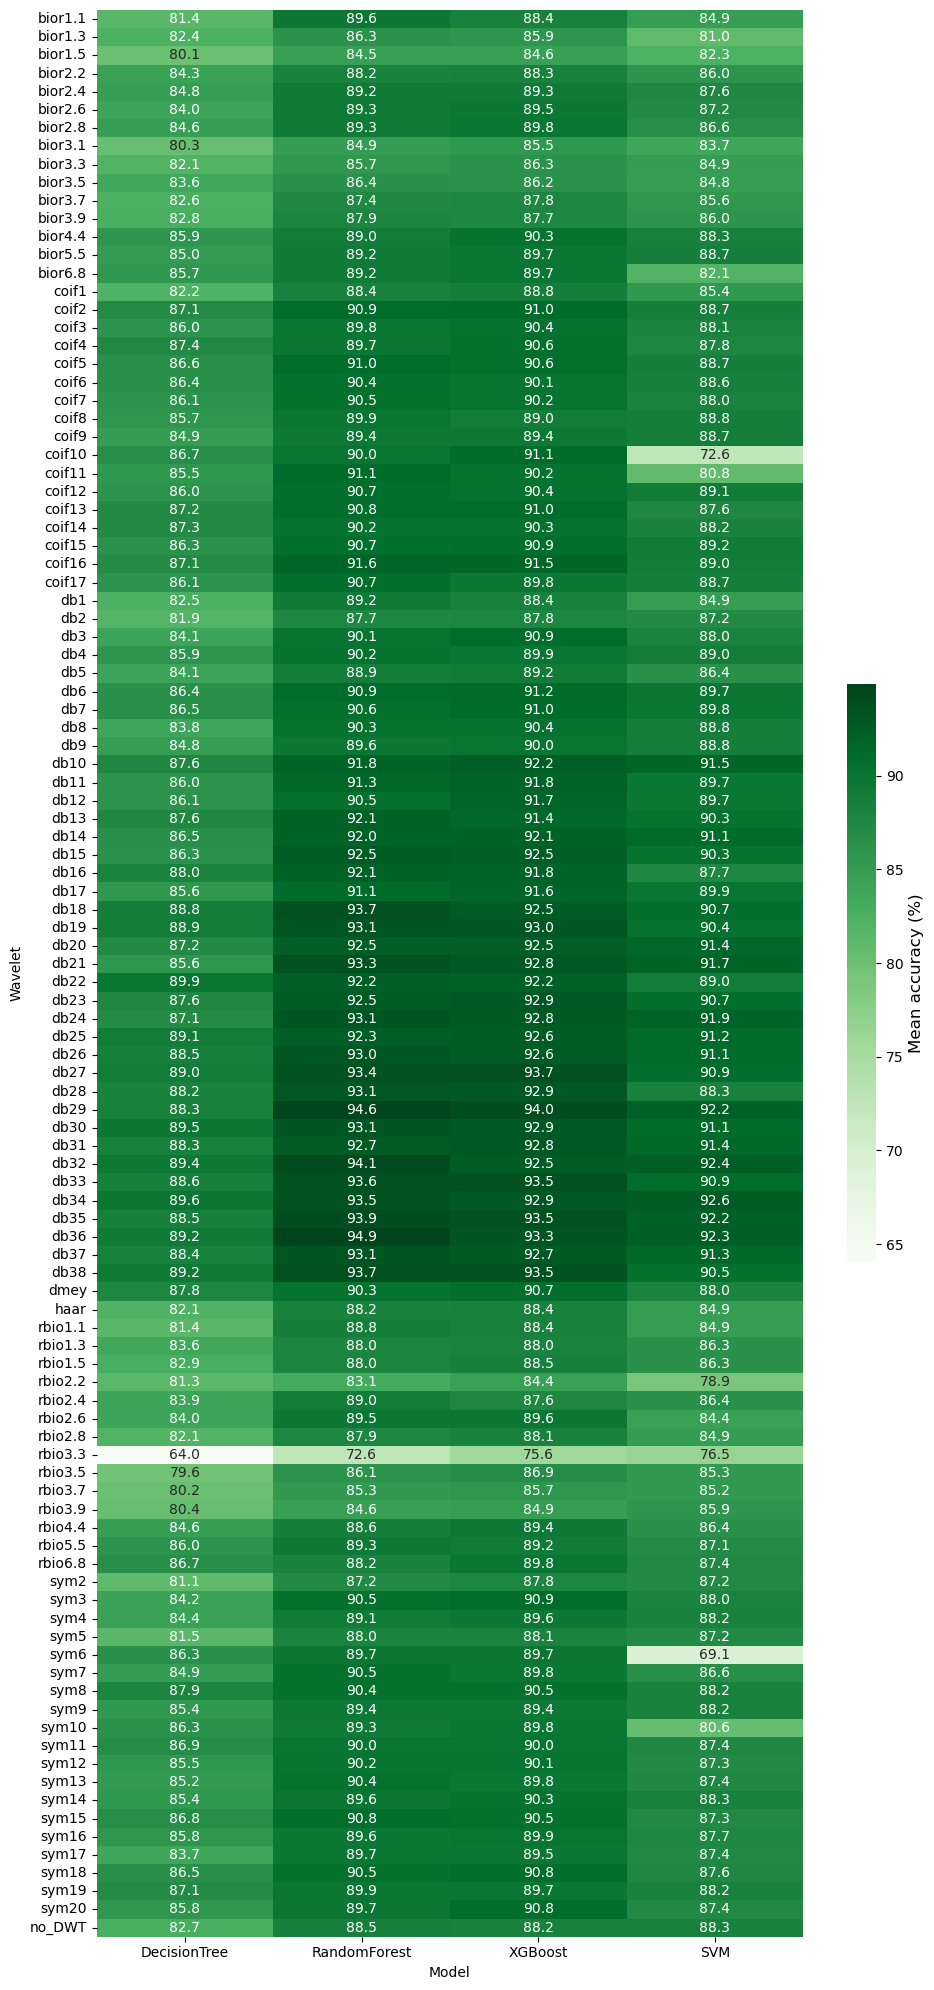

In [160]:
plt.figure(figsize=(10, 20))

# Round the DataFrame values to 3 decimal places for annotations
#annot_data = combined_results.applymap(lambda x: "{:.3f}".format(float(x)))

sns.heatmap(combined_results_no1920*100, annot=True, cmap='Greens', cbar=True, cbar_kws={'shrink': 0.3}, fmt=".1f")

# Adding label to cbar
plt.gcf().axes[-1].set_ylabel('Mean accuracy (%)', size=12)
plt.xlabel('Model')
plt.ylabel('Wavelet')
plt.tight_layout()
#plt.savefig('MSci_python_images/ML_all_wavelets_wholeevent.png', dpi=500)
plt.savefig('MSci_python_images/ML_all_wavelets_wholeeventno1920.png', dpi=500)
plt.show()

In [172]:
df_compare_no1920 = pd.DataFrame(columns=['Model', "% accuracy diff"])
results_no1920 = []

# Perform one-sample t-test for each model
for model in combined_results_no1920.columns:
    highest_accuracy = np.max(combined_results_no1920[model].drop('no_DWT'))  # Exclude 'no_DWT' from the max calculation
    no_dwt_accuracy = combined_results_no1920.loc['no_DWT', model]

    # Create a DataFrame for each model's results and add it to the list
    results_no1920.append(pd.DataFrame({'Model': [model], "No DWT Accuracy": no_dwt_accuracy*100, "Highest Accuracy": highest_accuracy*100 , "% accuracy diff": 100*(highest_accuracy - no_dwt_accuracy)}))
    
    
df_compare_no1920 = pd.concat(results_no1920, axis=0)

df_compare_no1920

,Model,No DWT Accuracy,Highest Accuracy,% accuracy diff
0,DecisionTree,82.740124,89.911864,7.171740
0,RandomForest,88.531989,94.876146,6.344157
0,XGBoost,88.236379,94.000058,5.763678
0,SVM,88.271245,92.646370,4.375125


In [175]:
highest_accuracy_wavelets = {}
for model in combined_results.columns:
    highest_accuracy_wavelets[model] = combined_results[model].drop('no_DWT').idxmax()

highest_accuracy_wavelets

{'DecisionTree': 'db37',
 'RandomForest': 'db36',
 'XGBoost': 'db29',
 'SVM': 'db35'}

Best model:
- Random Forest with db36 wavelet

t-test

In [247]:
from sklearn.model_selection import KFold
from scipy import stats
from sklearn.preprocessing import RobustScaler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE


def ML_no_and_best_wavelet_ttest(df, models, model_names):
    
    n_folds = 30
    
    results = {name: [] for name in model_names}

    
    
    for model_name, model in zip(model_names, models):
        col_wavelet = highest_accuracy_wavelets[model_name]
        col_noDWT = 'no_DWT'
        
        features_wavelet = df[col_wavelet][0]
        features_noDWT = df[col_noDWT][0]


        
        scaler = RobustScaler()
        X_wavelet = scaler.fit_transform(features_wavelet)
        X_noDWT = scaler.fit_transform(features_noDWT)
        
        y_wav = labels_all_wavelet_merged_df_drop[col_wavelet][0][:len(X_wavelet)]
        y_noDWT = labels_all_wavelet_merged_df_drop[col_noDWT][0][:len(X_noDWT)]

        # Initialize k-fold cross-validation
        kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

        # Create a pipeline with SMOTE and the specified model
        clf_pipeline = Pipeline([
            ('smote', SMOTE(random_state=42)),
            ('model', model())
        ])

        # Perform k-fold CV
        accuracies_wavelet = cross_val_score(clf_pipeline, X_wavelet, y_wav, cv=kf, scoring='accuracy', n_jobs=-1)  # Use parallel processing
        accuracies_noDWT = cross_val_score(clf_pipeline, X_noDWT, y_noDWT, cv=kf, scoring='accuracy', n_jobs=-1) 
    
    
        t_statistic, p_value = stats.ttest_rel(accuracies_wavelet, accuracies_noDWT)
    
        results[model_name] = p_value
    
    return results

In [248]:
ML_no_and_best_wavelet_ttest(new_df_flat_drop, models, model_names)

NameError: name 'new_df_flat_drop' is not defined

### Feedback

- could compare SNR

- rbio3.1 causing problems + really bad wavelet so have removed